# SET DESIRED EVALUATION PARAMS HERE

In [1]:
SPLIT = 'dev' # 'dev' or 'test'
TEMPERATURE = '0' # '0', '0.1' or '1'
MODEL = 'davinci' # 'flan-t5', 'neox' or 'davinci'
ONE_SHOT = False # True or False

# Imports

In [2]:
import re
import regex
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Levenshtein import distance
from collections import Counter

# Constants

In [3]:
COLUMN_ORDER = ["raw", "Address (post town)", "Address (post code)", "Address (street)", "Charity Name", "Charity Number", "Annual Income", "Period End Date", "Annual Spending"]

In [4]:
if SPLIT == 'dev':
    if MODEL == 'flan-t5':
        pass
    elif MODEL == 'neox':
        if ONE_SHOT:
            pass
        else:
            if TEMPERATURE == '0':
                PREDICTION_RUNS_PATHS = [
                    'datasets/kleister_charity/dev-0/predictions/neox/2022-12-14T18-27-21_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=0, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=KleisterCharityParser).tsv',
                    'datasets/kleister_charity/dev-0/predictions/neox/2022-12-15T21-44-54_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=0, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=KleisterCharityParser).tsv',
                    'datasets/kleister_charity/dev-0/predictions/neox/2022-12-15T21-45-15_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=0, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=KleisterCharityParser).tsv',
                ]
                LOG_PATHS = [
                    '../logs/neox/2022-12-14T18-27-21_neox_temp_0.log',
                    '../logs/neox/2022-12-15T21-44-54_neox_temp_0.log',
                    '../logs/neox/2022-12-15T21-45-15_neox_temp_0.log',
                ]

            elif TEMPERATURE == '0.1':
                PREDICTION_RUNS_PATHS = [
                    'datasets/kleister_charity/dev-0/predictions/neox/2022-12-14T18-27-46_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=0.1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=KleisterCharityParser).tsv',
                    'datasets/kleister_charity/dev-0/predictions/neox/2022-12-15T21-45-42_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=0.1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=KleisterCharityParser).tsv',
                    'datasets/kleister_charity/dev-0/predictions/neox/2022-12-15T21-45-54_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=0.1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=KleisterCharityParser).tsv',
                ]
                LOG_PATHS = [
                    '../logs/neox/2022-12-14T18-27-46_neox_temp_0.1.log',
                    '../logs/neox/2022-12-15T21-45-42_neox_temp_0.1.log',
                    '../logs/neox/2022-12-15T21-45-54_neox_temp_0.1.log',
                ]

            elif TEMPERATURE == '1':
                PREDICTION_RUNS_PATHS = [
                    'datasets/kleister_charity/dev-0/predictions/neox/2022-12-11T00-25-32_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=KleisterCharityParser).tsv',
                    'datasets/kleister_charity/dev-0/predictions/neox/2022-12-11T00-56-12_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=KleisterCharityParser).tsv',
                    'datasets/kleister_charity/dev-0/predictions/neox/2022-12-12T02-26-28_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=KleisterCharityParser).tsv',
                ]
                LOG_PATHS = [
                    '../logs/neox/2022-12-11T00-25-32_neox_temp_1.log',
                    '../logs/neox/2022-12-11T00-56-12_neox_temp_1.log',
                    '../logs/neox/2022-12-12T02-26-28_neox_temp_1.log',
                ]

    elif MODEL == 'davinci':
        if ONE_SHOT:
            pass
        else:
            if TEMPERATURE == '0':
                PREDICTION_RUNS_PATHS = [
                    'datasets/kleister_charity/dev-0/predictions/davinci/2022-12-14T18-30-56_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=KleisterCharityParser).tsv',
                    'datasets/kleister_charity/dev-0/predictions/davinci/2022-12-15T16-36-13_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=KleisterCharityParser).tsv',
                    'datasets/kleister_charity/dev-0/predictions/davinci/2022-12-15T16-36-16_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=KleisterCharityParser).tsv',
                ]
                LOG_PATHS = [
                    '../logs/davinci/2022-12-14T18-30-56_davinci_temp_0.log',
                    '../logs/davinci/2022-12-15T16-36-13_davinci_temp_0.log',
                    '../logs/davinci/2022-12-15T16-36-16_davinci_temp_0.log',
                ]

            elif TEMPERATURE == '0.1':
                PREDICTION_RUNS_PATHS = [
                    'datasets/kleister_charity/dev-0/predictions/davinci/2022-12-14T23-49-26_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0.1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=KleisterCharityParser).tsv',
                    'datasets/kleister_charity/dev-0/predictions/davinci/2022-12-15T16-34-49_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0.1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=KleisterCharityParser).tsv',
                    'datasets/kleister_charity/dev-0/predictions/davinci/2022-12-15T16-35-20_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0.1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=KleisterCharityParser).tsv',
                ]
                LOG_PATHS = [
                    '../logs/davinci/2022-12-14T23-49-26_davinci_temp_0.1.log',
                    '../logs/davinci/2022-12-15T16-34-49_davinci_temp_0.1.log',
                    '../logs/davinci/2022-12-15T16-35-20_davinci_temp_0.1.log',
                ]
            
            elif TEMPERATURE == '1':
                PREDICTION_RUNS_PATHS = [
                    'datasets/kleister_charity/dev-0/predictions/davinci/2022-11-24T01-57-18_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=KleisterCharityParser).tsv',
                    'datasets/kleister_charity/dev-0/predictions/davinci/2022-12-09T20-16-34_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=KleisterCharityParser).tsv',
                    'datasets/kleister_charity/dev-0/predictions/davinci/2022-12-12T02-27-07_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=KleisterCharityParser).tsv',
                ]
                LOG_PATHS = [
                    '../logs/davinci/2022-11-24T01-57-18_davinci_temp_1.log',
                    '../logs/davinci/2022-12-09T20-16-34_davinci_temp_1.log',
                    '../logs/davinci/2022-12-12T02-27-07_davinci_temp_1.log',
                ]

elif SPLIT == 'test':
    pass

# Loading solution (expected.tsv)

In [5]:
if SPLIT == 'dev':
    expected = pd.read_csv('datasets/kleister_charity/dev-0/expected.tsv', sep='\t', header=None, names=['raw'])
elif SPLIT == 'test':
    expected = pd.read_csv('datasets/kleister_charity/test-A/expected.tsv', sep='\t', header=None, names=['raw'])

for key_value_pair in expected["raw"]:
    for key_value in key_value_pair.split(" "):
        key, value = key_value.split("=")
        expected.loc[expected["raw"] == key_value_pair, key] = value

# renaming and sorting for better readability
expected.columns = ["raw", "Address (post town)", "Address (post code)", "Charity Name", "Charity Number", "Period End Date", "Address (street)", "Annual Income",  "Annual Spending"]
expected = expected[COLUMN_ORDER]

expected = expected.drop(columns=["raw"])
expected.head()

,Address (post town),Address (post code),Address (street),Charity Name,Charity Number,Annual Income,Period End Date,Annual Spending
0,BROADWAY,WR12_7NL,NaN,Wormington_Village_Society,1155074,NaN,2018-07-31,NaN
1,WESTCLIFF-ON-SEA,SS0_8HX,47_SECOND_AVENUE,Havens_Christian_Hospice,1022119,10348000.00,2016-03-31,9415000.00
2,CHELTENHAM,GL50_3EP,BAYSHILL_ROAD,Cheltenham_Ladies_College,311722,32168000.00,2016-07-31,27972000.00
3,SHREWSBURY,SY3_7PQ,58_TRINITY_STREET,The_Sanata_Charitable_Trust,1132766,255653.00,2015-12-31,258287.00
4,WARE,SG11_2DY,NaN,Cantate_Youth_Choir,1039369,122836.00,2013-12-31,124446.00


## Stats of solution

In [6]:
print("Percentage of keys that actually have a value (are not NaN):")
expected.count() / len(expected)

Percentage of keys that actually have a value (are not NaN):


Address (post town)    0.959091
Address (post code)    0.968182
Address (street)       0.886364
Charity Name           1.000000
Charity Number         0.993182
Annual Income          0.986364
Period End Date        1.000000
Annual Spending        0.986364
dtype: float64

# Loading predictions (three runs)

In [7]:
prediction_runs_dfs = []
for prediction_run_path in PREDICTION_RUNS_PATHS:
    prediction_run_df = pd.read_csv(prediction_run_path, sep='\t', header=None, names=['raw'], skip_blank_lines=False)

    for raw_prediction in prediction_run_df["raw"]:
        if raw_prediction is np.nan:
            prediction_run_df.loc[prediction_run_df["raw"] == raw_prediction] = np.nan
            continue
        key_value_pairs = raw_prediction.split(" ")
        for key_value in key_value_pairs:
            key, value = key_value.split("=", 1)
            prediction_run_df.loc[prediction_run_df["raw"] == raw_prediction, key] = value
    
    prediction_run_df.columns = ["raw", "Address (post town)", "Address (post code)", "Address (street)", "Charity Name", "Charity Number", "Period End Date", "Annual Income", "Annual Spending"]
    prediction_run_df = prediction_run_df[COLUMN_ORDER]
    prediction_run_df = prediction_run_df.drop(columns=["raw"])
    prediction_runs_dfs.append(prediction_run_df)

assert len(prediction_runs_dfs) == 3

## Loading associated logs of predictions (three runs)

In [8]:
prediction_runs_logs = []
for log_path in LOG_PATHS:
    log_file = open(log_path, "r")
    log_lines = [line.strip() for line in log_file.readlines() if line.strip() and line.startswith("20") and "Raw value:" not in line]
    log_file.close()
    prediction_runs_logs.append(log_lines)

assert len(prediction_runs_logs) == 3

In [9]:
len(prediction_runs_logs[0])

34999

# Evaluations (answering RH1)
## RH1
> Unimodal approach can reach satisfactory performance while being more cost-efficient than current state-of-the-art multi-modal approaches

Where we define satisfactory performance as:
> 80% of the values for given and findable keys are correctly found (no distinction for the other 20%, they can be either wrong or missing (which is of course also wrong)). Correctness is defined as a case-insensitive (upper-casing everything) string match with some normalisation (details below).

## Normalisations

We normalise values for three keys as listed below. We don't normalise values of `Address (post code)`, `Charity Number`, `Period End Date`, `Annual Income`, `Annual Spending`.


### Address (post town)
Examples:
Solution | Predicted
| --- | --- |
OTTERY_ST_MARY | Ottery_St._Mary
Lichfield | City_of_Lichfield
Liverpool | City_of_Liverpool

Normalisation:
* `<Solution City>` vs. `City of <Solution City>` are both correct
* Levenshtein: edit distance of 1 (1 deletion or 1 addition, but not a substitution) counts as correct (e.g. St.Mary vs. St._Mary or St_Mary vs St._Mary)

### Address (street)
Examples: 
Solution | Predicted
| --- | --- |
36_BELLINGHAM_DRIVE | Unit_36_Bellingham_Drive
34_DECIMA_STREET | Sherborne_House,_34_Decima_Street
190_LONG_LANE | Scout_Centre,_Rear_190_Long_Lane
13_ROSSLYN_ROAD | Room_16,_ETNA_Community_Centre,_13_Rosslyn_Road
FURNIVAL_GATE | 2_Floor,_Midcity_House,_Furnival_Gate
7-14_Great_Dover_Street | 7_-_14_Great_Dover_Street
BROWNBERRIE_LANE | Leeds_Trinity_University,_Brownberrie_Lane

Normalisation: 
* Delete Spaces around "-" in both solution and prediction

Was considering generally cutting off at ,_ before or after the street but ultimately decided against it because it cannot be generally stated that having something in front or after the correct street would still make mail arrive at the destination.

Also: Levenshtein edit distance of 1 doesn't make sense here as getting the number wrong (e.g. 13 instead of 1) is a clear mistake.

### Charity Name
Examples:
Solution | Predicted
| --- | --- |
Cheltenham Ladies College | Cheltenham Ladies' College
Battersea_Dogs'_and_Cats'_Home | Battersea_Dogs'_&_Cats'_Home
Beer_Shmuel_Ltd. | Beer_Shmuel_Limited
Catch_22_Charity_Ltd. | Catch22
Richard_Hicks | Richard_Hicks_Charity
King's_Schools_Taunton_Ltd. | King's_Schools_Taunton_Limited
KEY_ENTERPRISES_(1983)_LTD. | KEY_ENTERPRISES_(1983)_LIMITED
Louth_Playgoers_Society_Ltd. | Louth_Playgoers_Society_Limited
Boxgrove_Village_Hall_and_Community_Centre | BOXGROVE_VILLAGE_HALL_&_COMMUNITY_CENTRE_CIO
London_Transport_Museum | London_Transport_Museum_Ltd.
The_Momc-Leigh_Park_Crafts_Initiative_Trust_Ltd. | THE_MOMC_-_LEIGH_PARK_CRAFTS_INITIATIVE_TRUST_LIMITED
King_Edward_Vi's_School_At_Chelmsford | King_Edward_VI_School_at_Chelmsford
The_Hope_Foundation_Ltd. | The_Hope_Foundation
Nottingham_Women's_Counselling_Service | The_Nottingham_Women's_Counselling_Service

Normalisation (+ give stats for how many values this applies):
* Cut off Ltd, Ltd. and Limited from the end of both prediction and solution 
* Replace "&" with "and" in both prediction and solution
* Delete Spaces around "-" in both prediction and solution
* Levenshtein: edit distance of 1 (1 deletion or 1 addition) counts as correct (e.g. St.Mary vs. St._Mary or St_Mary vs St._Mary, King_Edward_VI's_School vs. King_Edward_VI_School)


### Other Normalisations
Replaced uncommon character: ’ (U+2019) with ' (in the predictions and the solution) (applies to 4 values in the whole solution of the dev set)

In [10]:
def replace_quotation_mark(df):
    """
    Replace U+2019 (right single quotation mark) with U+0027 (apostrophe) in a dataframe and return the number of replacements.
    """
    count = 0
    for column in df.columns:
        for index, value in df[column].items():
            if isinstance(value, str):
                if "’" in value:
                    df.loc[index, column] = value.replace("’", "'")
                    count += 1
    return count

for i, prediction_run_df in enumerate(prediction_runs_dfs):
    count = replace_quotation_mark(prediction_run_df)
    print(f"Replaced {count} quotation marks in prediction run {i}.")

count = replace_quotation_mark(expected)
print(f"Replaced {count} quotation marks in expected.")

Replaced 5 quotation marks in prediction run 0.
Replaced 5 quotation marks in prediction run 1.
Replaced 5 quotation marks in prediction run 2.
Replaced 4 quotation marks in expected.


In [11]:
def is_correct(key, expected_value, predicted_value):
    """
    Our definition of correctness for each key with the normalisation rules applied.
    """
    upper_cased_expected = str(expected_value).upper()
    upper_cased_predicted = str(predicted_value).upper()

    if key == "Address (post town)":
        if upper_cased_expected.startswith("CITY_OF_") or upper_cased_expected.startswith("TOWN_OF_"):
            upper_cased_expected = upper_cased_expected[8:]
        if upper_cased_predicted.startswith("CITY_OF_") or upper_cased_predicted.startswith("TOWN_OF_"):
            upper_cased_predicted = upper_cased_predicted[8:]
        return distance(upper_cased_expected, upper_cased_predicted, weights=(1, 1, 2)) <= 1

    elif key == "Address (street)":
        upper_cased_expected = re.sub(r"(_)(-)(_)", r"\2", upper_cased_expected)
        upper_cased_predicted = re.sub(r"(_)(-)(_)", r"\2", upper_cased_predicted)
        return upper_cased_expected == upper_cased_predicted
    
    elif key == "Charity Name":
        upper_cased_expected = re.sub(r"(_LTD|_LTD.|_LIMITED)$", "", upper_cased_expected)
        upper_cased_predicted = re.sub(r"(_LTD|_LTD.|_LIMITED)$", "", upper_cased_predicted)

        upper_cased_expected = re.sub(r"(&)", "and", upper_cased_expected)
        upper_cased_predicted = re.sub(r"(&)", "and", upper_cased_predicted)

        upper_cased_expected = re.sub(r"(_)(-)(_)", r"\2", upper_cased_expected)
        upper_cased_predicted = re.sub(r"(_)(-)(_)", r"\2", upper_cased_predicted)
        return distance(upper_cased_expected, upper_cased_predicted, weights=(1, 1, 2)) <= 1
    
    else:
        return upper_cased_expected == upper_cased_predicted

## Evaluating according to own definition of "correctness" and official

In [12]:
official_evaluations = [pd.DataFrame(np.nan, index=expected.index, columns=expected.columns) for _ in range(3)]
own_evaluations = [pd.DataFrame(np.nan, index=expected.index, columns=expected.columns) for _ in range(3)]
null_evaluations = [pd.DataFrame(np.zeros((4, len(expected.columns))), index=["TP", "FP", "FN", "TN"], columns=expected.columns) for _ in range(3)]

for i, prediction_run_df in enumerate(prediction_runs_dfs):
    for index, row in expected.iterrows():
        for column in expected.columns:
            if pd.notnull(row[column]): # because during parsing we look at the generations and if all subdocs are "null" or empty strings, it will not appear in the output and hence be NaN
                # FP: we predicted null and it was not null
                if pd.isnull(prediction_run_df.loc[index, column]):
                    null_evaluations[i].loc["FP", column] += 1

                # TN: we predicted not null (i.e. we predicted something) and it was not null
                else:
                    null_evaluations[i].loc["TN", column] += 1
                if is_correct(column, row[column], prediction_run_df.loc[index, column]):
                    own_evaluations[i].loc[index, column] = 1
                else:
                    own_evaluations[i].loc[index, column] = 0

                if str(row[column]).upper() == str(prediction_run_df.loc[index, column]).upper():
                    official_evaluations[i].loc[index, column] = 1
                else:
                    official_evaluations[i].loc[index, column] = 0

            else: # we don't care about the prediction in our own evaluation if the expected value is null
                # TP: we predicted null and it was null
                if pd.isnull(prediction_run_df.loc[index, column]):
                    null_evaluations[i].loc["TP", column] += 1
                # FN: we predicted not null and it was null
                else:
                    null_evaluations[i].loc["FN", column] += 1

                if pd.isnull(prediction_run_df.loc[index, column]):
                    official_evaluations[i].loc[index, column] = 1
                else:
                    official_evaluations[i].loc[index, column] = 0

in general we take macro average over the runs as it gives equal importance to each run (on the other hand, micro would give more importance to runs that have more predictions)

In [13]:
# own evaluation: only looks at the keys that are actually present in the document

# combine the three runs into one by taking the mean (together with the range around the mean (e.g. if we have [1.0, 0.3, 1.7] we get 1.0 as the mean and the range is from 0.3 to 1.7)) of the own evaluations by key of each run
avg_own_evaluation_by_key = pd.concat([own_evaluation.mean(axis=0, skipna=True) for own_evaluation in own_evaluations], axis=1).agg(["mean", "min", "max", lambda x: x.max() - x.min()], axis=1)
print(f"(macro)[over runs] (own) evaluation by key:\n{avg_own_evaluation_by_key}")
print(f"(macro)[over runs and keys] (own) average of correctly predicted values: {round(avg_own_evaluation_by_key['mean'].agg('mean'), 3)}")
print(f"(macro)[over runs and keys] (own) range of correctly predicted values: {round(avg_own_evaluation_by_key['<lambda>'].agg('mean'), 3)}")

# official evaluation (same as above but with the official evaluation)
avg_official_evaluation_by_key = pd.concat([official_evaluation.mean(axis=0, skipna=True) for official_evaluation in official_evaluations], axis=1).agg(["mean", "min", "max", lambda x: x.max() - x.min()], axis=1)
print(f"(macro)[over runs] (official) evaluation by key:\n{avg_official_evaluation_by_key}")
print(f"(macro)[over runs and keys] (official) average of correctly predicted values: {round(avg_official_evaluation_by_key['mean'].agg('mean'), 3)}")
print(f"(macro)[over runs and keys] (official) range of correctly predicted values: {round(avg_official_evaluation_by_key['<lambda>'].agg('mean'), 3)}")

(macro)[over runs] (own) evaluation by key:
                         mean       min       max  <lambda>
Address (post town)  0.790679  0.789100  0.791469  0.002370
Address (post code)  0.672926  0.671362  0.673709  0.002347
Address (street)     0.367521  0.366667  0.369231  0.002564
Charity Name         0.725000  0.725000  0.725000  0.000000
Charity Number       0.826087  0.823799  0.828375  0.004577
Annual Income        0.451613  0.449309  0.456221  0.006912
Period End Date      0.956818  0.956818  0.956818  0.000000
Annual Spending      0.477727  0.476959  0.479263  0.002304
(macro)[over runs and keys] (own) average of correctly predicted values: 0.659
(macro)[over runs and keys] (own) range of correctly predicted values: 0.003
(macro)[over runs] (official) evaluation by key:
                         mean       min       max  <lambda>
Address (post town)  0.753788  0.752273  0.754545  0.002273
Address (post code)  0.669697  0.668182  0.670455  0.002273
Address (street)     0.337121  

It is possible that the official evaluation is actually higher than our evaluation because it rewards correctly identifying null values whereas we don't care about the key-value pairs that are expected to be null.

In [14]:
print(f"(macro)[over runs] Correlation coefficient between own and official evaluation (by key): {round(np.corrcoef(avg_own_evaluation_by_key['mean'], avg_official_evaluation_by_key['mean'])[0, 1], 3)}")

(macro)[over runs] Correlation coefficient between own and official evaluation (by key): 0.976


## Null Evaluation

The question we want to answer here is how good we are with predicting `null` for a key (not in subdocs, but for whole document), specifically we also look at the F1 for only `null` → `F_1_{null}`.

In [15]:
null_scores_by_key_runs = []
for null_evaluation in null_evaluations:
    # micro average
    precision = null_evaluation.loc["TP", :].sum() / (null_evaluation.loc["TP", :].sum() + null_evaluation.loc["FP", :].sum())
    recall = null_evaluation.loc["TP", :].sum() / (null_evaluation.loc["TP", :].sum() + null_evaluation.loc["FN", :].sum())
    f1 = 2 * precision * recall / (precision + recall)
    
    # aggregating by key for later macro average
    null_scores_by_key = {}
    for key in null_evaluation.columns:   
        precision = null_evaluation.loc["TP", key] / (null_evaluation.loc["TP", key] + null_evaluation.loc["FP", key]) 
        recall = null_evaluation.loc["TP", key] / (null_evaluation.loc["TP", key] + null_evaluation.loc["FN", key])
        f1 = 2 * precision * recall / (precision + recall)
        null_scores_by_key[key] = {"precision": precision, "recall": recall, "f1": f1}

    null_scores_by_key = pd.DataFrame(null_scores_by_key).T
    null_scores_by_key_runs.append(null_scores_by_key)

print(f"(macro)[over runs] Precision for null by key:\n{pd.concat([null_scores_by_key['precision'] for null_scores_by_key in null_scores_by_key_runs], axis=1).agg(['mean', 'min', 'max'], axis=1)}")
print(f"(macro)[over runs] Recall for null by key:\n{pd.concat([null_scores_by_key['recall'] for null_scores_by_key in null_scores_by_key_runs], axis=1).agg(['mean', 'min', 'max'], axis=1)}")
print(f"(macro)[over runs] F1 score for null by key:\n{pd.concat([null_scores_by_key['f1'] for null_scores_by_key in null_scores_by_key_runs], axis=1).agg(['mean', 'min', 'max'], axis=1)}")


print(f"(macro)[over runs with micro average] Precision for null: {np.mean([null_evaluation.loc['TP', :].sum() / (null_evaluation.loc['TP', :].sum() + null_evaluation.loc['FP', :].sum()) for null_evaluation in null_evaluations])}")
print(f"(macro)[over runs with micro average] Recall for null: {np.mean([null_evaluation.loc['TP', :].sum() / (null_evaluation.loc['TP', :].sum() + null_evaluation.loc['FN', :].sum()) for null_evaluation in null_evaluations])}")
print(f"(macro)[over runs with micro average] F1 score for null: {np.mean([2 * null_evaluation.loc['TP', :].sum() / (2 * null_evaluation.loc['TP', :].sum() + null_evaluation.loc['FP', :].sum() + null_evaluation.loc['FN', :].sum()) for null_evaluation in null_evaluations])}")

print(f"(macro)[over runs with macro over keys] F1 score for null: {np.mean([null_scores_by_key['f1'].mean() for null_scores_by_key in null_scores_by_key_runs])}")

(macro)[over runs] Precision for null by key:
                         mean       min       max
Address (post town)  0.500000  0.500000  0.500000
Address (post code)  0.615385  0.615385  0.615385
Address (street)     0.454545  0.454545  0.454545
Charity Name         0.000000  0.000000  0.000000
Charity Number       0.230769  0.230769  0.230769
Annual Income        0.290476  0.285714  0.300000
Period End Date      0.000000  0.000000  0.000000
Annual Spending      0.290476  0.285714  0.300000
(macro)[over runs] Recall for null by key:
                         mean       min       max
Address (post town)  0.055556  0.055556  0.055556
Address (post code)  0.571429  0.571429  0.571429
Address (street)     0.100000  0.100000  0.100000
Charity Name              NaN       NaN       NaN
Charity Number       1.000000  1.000000  1.000000
Annual Income        1.000000  1.000000  1.000000
Period End Date           NaN       NaN       NaN
Annual Spending      1.000000  1.000000  1.000000
(macro)[ove

/var/folders/t1/8_xptc456_9bnyk0lkdrjql00000gn/T/ipykernel_76275/2220019627.py:12: RuntimeWarning: invalid value encountered in double_scalars
  recall = null_evaluation.loc["TP", key] / (null_evaluation.loc["TP", key] + null_evaluation.loc["FN", key])


It makes sense that micro and macro average of the  are quite close together because as we saw in the beginning, almost all keys are given in the data set. There is no big "class" (key) imbalance.

## Unifications, collisions, lenient accuracy and looking at repetetiveness (all on subdocument level)

### Definition of Unification
A unification is whenever there are two or more non-null values coming from the subdoc predictions for the same key. If there is only one non-null value coming from the subdocs (which is always the case if there only is one subdoc but can also happen with more than one subdoc) then it's not a unification.

A trivial unification is a unification where all values are the same.

### Definition of Collision
Given a unification, we describe two or more different values for the same key as the unification having a collision. 

So a unification is either trivial (all values the same) or it has a collision.

### Definition of a Full Collision
Same as a collision but with the constraint that *all* values are different (not just any two).

In [16]:
empty_key_dict = {
    "Address (post town)": None,
    "Address (post code)": None,
    "Address (street)": None,
    "Charity Name": None,
    "Charity Number": None,
    "Annual Income": None,
    "Period End Date": None,
    "Annual Spending": None,
}

runs_predictions_stats_dict = []
runs_predictions_dict = []

for i, log_lines in enumerate(prediction_runs_logs):
    print(f"Processing run {i}")
    single_run_prediction_stats_dict = []
    single_run_predictions_dict = []

    single_run_num_empty_string_predictions = 0
    for line in log_lines:
        if "Predicting document" in line: # this is the beginning of a prediction
            # create a new dictionary for this document
            single_run_prediction_stats_dict.append({
                "num_subdocs": None,
                "num_unifications": 0,
                "collision_per_key": empty_key_dict.copy(),
                "full_collision_per_key": empty_key_dict.copy(),
                "num_unified_values_per_key": empty_key_dict.copy(),
                "correct_in_any_subdoc_per_key": empty_key_dict.copy(),
                "collision_percentage": None,
                "full_collision_percentage": None,
                "correct_in_any_subdoc_percentage": None,
            })
            single_run_predictions_dict.append(empty_key_dict.copy())

        elif "Final prediction for document" in line: # this is the end of a prediction
            # calculate the percentages
            single_run_prediction_stats_dict[-1]["collision_percentage"] = np.mean([x for x in single_run_prediction_stats_dict[-1]["collision_per_key"].values() if x is not None])
            single_run_prediction_stats_dict[-1]["full_collision_percentage"] = np.mean([x for x in single_run_prediction_stats_dict[-1]["full_collision_per_key"].values() if x is not None])
            single_run_prediction_stats_dict[-1]["correct_in_any_subdoc_percentage"] = np.mean([x for x in single_run_prediction_stats_dict[-1]["correct_in_any_subdoc_per_key"].values() if x is not None])
    
        elif "No subdocs necessary" in line:
            single_run_prediction_stats_dict[-1]["num_subdocs"] = 1

        elif "Split document into" in line:
            num_subdocs = int(re.search("into (\d+) subdocuments", line).group(1))
            single_run_prediction_stats_dict[-1]["num_subdocs"] = num_subdocs

        elif "- parse_model_output() - Key:" in line:
            key = re.search("- parse_model_output\(\) - Key: (.*):", line).group(1)
            # the prediction is always in the next line (unless the key was not predicted at all) or the prediction is an empty string
            try:
                prediction = re.search("- parse_model_output\(\) - Stripped value: (.*)", log_lines[log_lines.index(line)+1]).group(1)
                

            except AttributeError:
                single_run_num_empty_string_predictions += 1
                prediction = "[METADATA]: EMPTY_STRING_PREDICTION"
                
            if single_run_predictions_dict[-1][key] is None:
                    single_run_predictions_dict[-1][key] = [prediction]
            else:
                single_run_predictions_dict[-1][key].append(prediction)

        elif "Unification necessary for key" in line:
            key = re.search("Unification necessary for key (.*)", line).group(1)
            single_run_prediction_stats_dict[-1]["collision_per_key"][key] = False
            single_run_prediction_stats_dict[-1]["full_collision_per_key"][key] = False
            values = re.search("Unifying \d+ \(lowered\) values (.*)", log_lines[log_lines.index(line)+1]).group(1)

            # values is the string representation of a list, so we can use eval to turn it into a list
            values = eval(values)
            unified_values = int(re.search("Unifying (\d+) \(lowered\) values", log_lines[log_lines.index(line)+1]).group(1))

            assert unified_values == len(values) # sanity check

            # if there is more than 1 value, then it's a unification (because these values don't include null values)
            if len(values) > 1:
                single_run_prediction_stats_dict[-1]["num_unifications"] += 1

                # if there are more than 1 different values, then it's a collision
                if len(set(values)) > 1:
                    single_run_prediction_stats_dict[-1]["collision_per_key"][key] = True

                # if the length of the set is equal to the length of the list, then it's a full collision
                if len(set(values)) == len(values):
                    single_run_prediction_stats_dict[-1]["full_collision_per_key"][key] = True

            
            single_run_prediction_stats_dict[-1]["num_unified_values_per_key"][key] = unified_values

            # which document are we in?
            doc_num = len(single_run_prediction_stats_dict) - 1

            # get the correct value for this key
            correct_value = expected.iloc[doc_num][key]

            # if it's NaN, then we were not supposed to predict anything for this key but we did (in at least one subdoc)
            if pd.isna(correct_value):
                single_run_prediction_stats_dict[-1]["correct_in_any_subdoc_per_key"][key] = False # TODO: ask if this is correct
                continue

            # we have to transform the values in the list to the same format as the correct value
            values = [x.replace(" ", "_").replace(":", "_").upper() for x in values]

            # also transform the correct value to uppercase
            correct_value = str(correct_value).upper()

            # if the correct value is in the list of values, then it's correct in at least one subdoc
            if correct_value in values:
                single_run_prediction_stats_dict[-1]["correct_in_any_subdoc_per_key"][key] = True

            else:
                single_run_prediction_stats_dict[-1]["correct_in_any_subdoc_per_key"][key] = False

        elif "Key not found in any subdoc" in line: # null was predicted in all subdocs
            key = re.search("Key not found in any subdoc (.*)", line).group(1)
            single_run_prediction_stats_dict[-1]["collision_per_key"][key] = False
            single_run_prediction_stats_dict[-1]["full_collision_per_key"][key] = False
            single_run_prediction_stats_dict[-1]["num_unified_values_per_key"][key] = 0

            # get the correct value for this key
            correct_value = expected.iloc[len(single_run_prediction_stats_dict) - 1][key]

            if pd.isna(correct_value):
                single_run_prediction_stats_dict[-1]["correct_in_any_subdoc_per_key"][key] = True
            else:
                single_run_prediction_stats_dict[-1]["correct_in_any_subdoc_per_key"][key] = False

    print("Number of empty string predictions:", single_run_num_empty_string_predictions)
    runs_predictions_stats_dict.append(single_run_prediction_stats_dict)
    runs_predictions_dict.append(single_run_predictions_dict)


Processing run 0


/Users/ivo/Library/Caches/pypoetry/virtualenvs/uni-kie-JrmAaldC-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ivo/Library/Caches/pypoetry/virtualenvs/uni-kie-JrmAaldC-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number of empty string predictions: 9
Processing run 1
Number of empty string predictions: 9
Processing run 2
Number of empty string predictions: 9


In [17]:
# sanity check -> all docs with x number of subdocs should have x predictions for each key (also for the keys that have an empty string prediction
# because we added [METADATA]: EMPTY_STRING_PREDICTION to the list of predictions
for _, single_run_predictions_stats_dict in enumerate(runs_predictions_stats_dict):
    for j, document in enumerate(single_run_predictions_stats_dict):
        for key in single_run_predictions_dict[j].keys():
            assert len(single_run_predictions_dict[j][key]) == single_run_prediction_stats_dict[j]["num_subdocs"]
        

In [18]:
runs_prediction_stats_df =[pd.DataFrame(runs_predictions_stats_dict[i]) for i in range(len(runs_predictions_stats_dict))]
runs_prediction_stats_df[0].head()

,num_subdocs,num_unifications,collision_per_key,full_collision_per_key,num_unified_values_per_key,correct_in_any_subdoc_per_key,collision_percentage,full_collision_percentage,correct_in_any_subdoc_percentage
0,1,0,"{'Address (post town)': None, 'Address (post c...","{'Address (post town)': None, 'Address (post c...","{'Address (post town)': None, 'Address (post c...","{'Address (post town)': None, 'Address (post c...",NaN,NaN,NaN
1,9,8,"{'Address (post town)': True, 'Address (post c...","{'Address (post town)': True, 'Address (post c...","{'Address (post town)': 2, 'Address (post code...","{'Address (post town)': True, 'Address (post c...",0.750,0.625,0.750
2,8,8,"{'Address (post town)': True, 'Address (post c...","{'Address (post town)': False, 'Address (post ...","{'Address (post town)': 5, 'Address (post code...","{'Address (post town)': True, 'Address (post c...",0.875,0.125,0.750
3,2,2,"{'Address (post town)': False, 'Address (post ...","{'Address (post town)': False, 'Address (post ...","{'Address (post town)': 1, 'Address (post code...","{'Address (post town)': True, 'Address (post c...",0.250,0.250,0.750
4,3,4,"{'Address (post town)': False, 'Address (post ...","{'Address (post town)': False, 'Address (post ...","{'Address (post town)': 1, 'Address (post code...","{'Address (post town)': True, 'Address (post c...",0.250,0.250,0.875


In [19]:
# replace NaN values in column `correct_in_any_subdoc_percentage` with the accuracy as per official_evaluation (this is not recorded in the log traversal)
for i in range(len(runs_prediction_stats_df)):
    runs_prediction_stats_df[i]["correct_in_any_subdoc_percentage"] = runs_prediction_stats_df[i]["correct_in_any_subdoc_percentage"].fillna(official_evaluations[i].mean(axis=1, skipna=True))

# # replace None values in column `correct_in_any_subdoc_per_key` of the rows with 1 subdoc with True/False as taken from the official_evaluation
for i, single_run_prediction_stats_df in enumerate(runs_prediction_stats_df):
    for j in range(len(single_run_prediction_stats_df)):
        if single_run_prediction_stats_df.iloc[j]["num_subdocs"] == 1:
            for key in single_run_prediction_stats_df.iloc[j]["correct_in_any_subdoc_per_key"].keys():
                single_run_prediction_stats_df.iloc[j]["correct_in_any_subdoc_per_key"][key] = bool(official_evaluations[i].iloc[j][key])

## Lenient Accuracy

Note: In the case that not in any subdoc a value was predicted (all null) we check if the correct solution is in fact null and then consider that in any subdoc the corect value (which is null) was found (in reality it was correctly identified in all). We cannot do the opposite (check if it was null in any subdoc) and then say it was correctly identified (if it was indeed null) because of the subdoc structure where any given subdoc is not guaranteed to have all key-value pairs.

In [20]:
runs_lenient_accuracy_by_key = []

for i, single_run_prediction_stats_df in enumerate(runs_prediction_stats_df):

    # a single entry is a dictionary with the correctness for each key (True, False, or None)
    lenient_correctness_over_docs = single_run_prediction_stats_df["correct_in_any_subdoc_per_key"].tolist()

    single_run_lenient_accuracy_by_key = pd.DataFrame()

    for key in lenient_correctness_over_docs[0].keys():
        correctness = [x[key] for x in lenient_correctness_over_docs]
        avg_lenient_accuracy = np.mean([x for x in correctness if x is not None])
        single_run_lenient_accuracy_by_key[key] = [avg_lenient_accuracy]

    runs_lenient_accuracy_by_key.append(single_run_lenient_accuracy_by_key)
    print("Run", i)
    print(f"(official) (macro)[average over the keys] Lenient accuracy: {round(single_run_lenient_accuracy_by_key.mean(axis=1).mean(), 3)}")
    print(f"(official) (macro)[average over documents] Lenient accuracy: {round(single_run_prediction_stats_df['correct_in_any_subdoc_percentage'].mean(), 3)}")

print("Combined runs:")
# combine the three runs into one by taking the mean (together with the range around the mean (e.g. if we have [1.0, 0.3, 1.7] we get 1.0 as the mean and the range is from 0.3 to 1.7)) of the lenient accuracies by key of each run
avg_lenient_accuracy_by_key = pd.concat([lenient_accuracy_by_key for lenient_accuracy_by_key in runs_lenient_accuracy_by_key], axis=0).agg(["mean", "min", "max", lambda x: x.max() - x.min()], axis=0)
print(f"(official) (macro)[average over the runs] Lenient accuracy by key:\n{avg_lenient_accuracy_by_key.T}")

print(f"(official) (macro)[average over the runs and the keys] Lenient accuracy: {round(avg_lenient_accuracy_by_key.T['mean'].mean(), 3)}")
print(f"(official) (macro)[average over the runs and keys] Range of lenient accuracy by key: {round(avg_lenient_accuracy_by_key.T['<lambda>'].mean(), 3)}")

Run 0
(official) (macro)[average over the keys] Lenient accuracy: 0.696
(official) (macro)[average over documents] Lenient accuracy: 0.696
Run 1
(official) (macro)[average over the keys] Lenient accuracy: 0.696
(official) (macro)[average over documents] Lenient accuracy: 0.696
Run 2
(official) (macro)[average over the keys] Lenient accuracy: 0.695
(official) (macro)[average over documents] Lenient accuracy: 0.695
Combined runs:
(official) (macro)[average over the runs] Lenient accuracy by key:
                         mean       min       max  <lambda>
Address (post town)  0.787879  0.786364  0.788636  0.002273
Address (post code)  0.700000  0.697727  0.702273  0.004545
Address (street)     0.384091  0.384091  0.384091  0.000000
Charity Name         0.621212  0.620455  0.622727  0.002273
Charity Number       0.944697  0.943182  0.945455  0.002273
Annual Income        0.573485  0.570455  0.575000  0.004545
Period End Date      0.963636  0.963636  0.963636  0.000000
Annual Spending      

In [21]:
runs_relative_lenient_accuracy_improvement = []
runs_absolute_lenient_accuracy_improvement = []
runs_accuracies_by_key = []

for i, official_evaluation in enumerate(official_evaluations):
    print("Run", i)
    accuracy_by_key = official_evaluation.mean(axis=0, skipna=True)
    runs_accuracies_by_key.append(accuracy_by_key)
    print("(official) Relative improvement in accuracy (lenient vs. strict):")
    for key in accuracy_by_key.keys():
        print(f"{key}: {round((runs_lenient_accuracy_by_key[i][key].values[0] - accuracy_by_key[key]) / accuracy_by_key[key] * 100, 3)}%")


    macro_relative_improvement = (single_run_lenient_accuracy_by_key.mean(axis=1).mean() - accuracy_by_key.mean()) / accuracy_by_key.mean() * 100
    print(f"(macro)[average over keys] (official) Relative improvement in accuracy (lenient vs. strict): {round(macro_relative_improvement, 3)}%")
    runs_relative_lenient_accuracy_improvement.append(macro_relative_improvement)

    macro_absolute_improvement = single_run_lenient_accuracy_by_key.mean(axis=1).mean() - accuracy_by_key.mean()
    print(f"(macro)[average over keys] (official) Absolute improvement in accuracy (lenient vs. strict): {round(macro_absolute_improvement, 3)}")
    runs_absolute_lenient_accuracy_improvement.append(macro_absolute_improvement)

print("Combined runs:")
print(f"(macro)[average over runs] (official) Relative improvement in accuracy (lenient vs. strict): {round(np.mean(runs_relative_lenient_accuracy_improvement), 3)}%")
print(f"(macro)[average over runs] (official) Absolute improvement in accuracy (lenient vs. strict): {round(np.mean(runs_absolute_lenient_accuracy_improvement), 3)}")

Run 0
(official) Relative improvement in accuracy (lenient vs. strict):
Address (post town): 4.518%
Address (post code): 4.746%
Address (street): 14.189%
Charity Name: 3.802%
Charity Number: 13.973%
Annual Income: 25.871%
Period End Date: 0.713%
Annual Spending: 21.596%
(macro)[average over keys] (official) Relative improvement in accuracy (lenient vs. strict): 9.249%
(macro)[average over keys] (official) Absolute improvement in accuracy (lenient vs. strict): 0.059
Run 1
(official) Relative improvement in accuracy (lenient vs. strict):
Address (post town): 4.532%
Address (post code): 4.407%
Address (street): 13.423%
Charity Name: 4.183%
Charity Number: 14.601%
Annual Income: 24.02%
Period End Date: 0.713%
Annual Spending: 22.066%
(macro)[average over keys] (official) Relative improvement in accuracy (lenient vs. strict): 9.201%
(macro)[average over keys] (official) Absolute improvement in accuracy (lenient vs. strict): 0.059
Run 2
(official) Relative improvement in accuracy (lenient vs

## Frequency and presence penalty motivation for not looking at those parameters

First, let's check how often the same value for different keys is predicted to see if it's generally correct to assume that values shouldn't be repeated (which could be combated by e.g. increasing the freq. and presence penalties).

In [22]:
def has_two_values_for_different_keys(row):
    return len(row) == len(set(row))

num_of_same_value_rows = 0
for i in range(len(expected)):
    if not has_two_values_for_different_keys(expected.iloc[i]):
        num_of_same_value_rows += 1

print(f"Found {num_of_same_value_rows} rows that have the same value for different keys, that's {round(num_of_same_value_rows / len(expected) * 100, 3)}% of the dataset.")


Found 10 rows that have the same value for different keys, that's 2.273% of the dataset.


So, generally speaking, there shouldn't be the same value for different keys.
A repetition of the same value would also be correct in the case of a document having more than 1 null value, where a correct generation would contain `"null"` multiple times. Let's look at how often this is the case:

In [23]:
print("Documents that have 2 or more NaN values for any two keys:")
expected[expected.isna().sum(axis=1) >= 2]

Documents that have 2 or more NaN values for any two keys:


,Address (post town),Address (post code),Address (street),Charity Name,Charity Number,Annual Income,Period End Date,Annual Spending
0,BROADWAY,WR12_7NL,NaN,Wormington_Village_Society,1155074,NaN,2018-07-31,NaN
71,SHEFFIELD,S7_1FE,133_ABBEYDALE_ROAD,Families_Relief,1168193,NaN,2017-12-31,NaN
83,NaN,NaN,NaN,St_Marina_Coptic_Orthodox_Church-Bristol,1149736,72998.00,2017-03-31,31077.00
100,MAIDSTONE,ME16_8RL,5A_TONBRIDGE_ROAD,Lighthouse_Global_Network,1163804,NaN,2016-05-31,NaN
171,TELFORD,NaN,NaN,Randlay_Roundabouts_Pre-School,NaN,NaN,2014-08-31,NaN
176,NaN,NaN,NaN,Age_Concern_Harlow,264451,36071.00,2015-03-31,31410.21
204,NaN,NaN,NaN,Davis_Estate_Community_Centre,294242,30116.00,2018-03-31,31244.00
210,NaN,NaN,NaN,The_Childrens_Welfare_and_Research_Foundation,1101160,115677.00,2016-06-30,72333.00
211,NaN,NaN,NaN,Sutton_Family_Church,1104168,143120.55,2013-12-31,108294.79
221,NaN,NaN,NaN,The_Silvers_Workshop,1159283,6445.00,2016-04-06,5249.00


In [24]:
more_than_one_missing_value_in_solution_pct = round(len(expected[expected.isna().sum(axis=1) >= 2]) / len(expected) * 100, 3)
print(f"Percentage of documents that have 2 or more NaN values for any two keys: {more_than_one_missing_value_in_solution_pct}%")

Percentage of documents that have 2 or more NaN values for any two keys: 3.636%


So, generally speaking, we shouldn't have more than 1 null in our generations, so we can now generally assume that repetition of the same value in the generations is incorrect.

Now, let's check how often we have repetition (i.e. the same value (including null's) for different keys) in the (subdoc) predictions. If this is very high then it would make sense to look into tuning the presence and frequency penalties.

In [25]:
for i, single_run_prediction_stats_dict in enumerate(runs_predictions_stats_dict): # for each run
    print("Run", i)
    for j in range(len(runs_predictions_stats_dict[i])): # for each document
        single_run_prediction_stats_dict[j]["pct_unique_predictions_per_subdoc"] = {} # this is min 0.125 (1/8) in the case that all predictions are the same (e.g. all 'null') and max 1.0 (all predictions are unique)
        single_run_prediction_stats_dict[j]["pct_unique_predictions_per_subdoc_ignore_null"] = {} # this is nan if all predictions are null, and also min 0.125
        for subdoc in range(single_run_prediction_stats_dict[j]["num_subdocs"]): # for each subdoc            
            # get the predictions for each key
            predictions_for_keys = [runs_predictions_dict[i][j][key][subdoc] for key in runs_predictions_dict[i][j].keys()]

            # get the number of unique predictions
            num_unique_predictions = len(set(predictions_for_keys)) # this is at least 1, cannot be 0

            # add the percentage of unique predictions to the dictionary
            single_run_prediction_stats_dict[j]["pct_unique_predictions_per_subdoc"][subdoc] = num_unique_predictions / len(predictions_for_keys)

            # get the number of unique predictions ignoring null values
            num_unique_predictions_ignore_null = len(set([x for x in predictions_for_keys if not x.upper().startswith("NULL") and x != "[METADATA]: EMPTY_STRING_PREDICTION"]))

            num_predictions_ignore_null = len([x for x in predictions_for_keys if not x.upper().startswith("NULL") and x != "[METADATA]: EMPTY_STRING_PREDICTION"]) # this is 0 if all the predictions are null or empty string

            # in this case, we set the number of unique predictions to nan
            if num_unique_predictions_ignore_null == 0:
                single_run_prediction_stats_dict[j]["pct_unique_predictions_per_subdoc_ignore_null"][subdoc] = np.nan
                continue
            # add the percentage of unique predictions (ignoring null) to the dictionary
            single_run_prediction_stats_dict[j]["pct_unique_predictions_per_subdoc_ignore_null"][subdoc] = num_unique_predictions_ignore_null / num_predictions_ignore_null

    # (micro) average percentage of unique predictions (ignoring null) per subdoc:"
    # every doc has some number of subdocs, and every subdoc has some percentage of unique predictions (ignoring null)
    # we want to average over all the subdocs in all the docs

    # first, we get the list of all the percentages of unique predictions (ignoring null) per subdoc
    all_pct_unique_predictions_per_subdoc_ignore_null = []
    for k in range(len(runs_predictions_stats_dict[i])):
        all_pct_unique_predictions_per_subdoc_ignore_null.extend(list(single_run_prediction_stats_dict[k]["pct_unique_predictions_per_subdoc_ignore_null"].values()))

    # then we average over all the percentages of unique predictions (ignoring null) per subdoc
    micro_average_pct_unique_predictions_per_subdoc_ignore_null = np.nanmean(all_pct_unique_predictions_per_subdoc_ignore_null)
    print(f"(micro) average percentage of unique predictions (ignoring null) per subdoc: {round(micro_average_pct_unique_predictions_per_subdoc_ignore_null, 3)}")

    # now we do the same thing, but for the percentage of unique predictions (not ignoring null)
    all_pct_unique_predictions_per_subdoc = []
    for k in range(len(runs_predictions_stats_dict[i])):
        all_pct_unique_predictions_per_subdoc.extend(list(single_run_prediction_stats_dict[k]["pct_unique_predictions_per_subdoc"].values()))

    micro_average_pct_unique_predictions_per_subdoc = np.nanmean(all_pct_unique_predictions_per_subdoc)
    print(f"(micro) average percentage of unique predictions per subdoc: {round(micro_average_pct_unique_predictions_per_subdoc, 3)}")

    # we do the same thing, but for the macro average (over the subdocs for each doc)
    macro_average_pct_unique_predictions_per_subdoc_ignore_null = np.nanmean([np.nanmean(list(single_run_prediction_stats_dict[k]["pct_unique_predictions_per_subdoc_ignore_null"].values())) for k in range(len(runs_predictions_stats_dict[i]))])
    print(f"(macro)[over subdocs of each doc] average percentage of unique predictions (ignoring null) per subdoc: {round(macro_average_pct_unique_predictions_per_subdoc_ignore_null, 3)}")

    macro_average_pct_unique_predictions_per_subdoc = np.nanmean([np.nanmean(list(single_run_prediction_stats_dict[k]["pct_unique_predictions_per_subdoc"].values())) for k in range(len(runs_predictions_stats_dict[i]))])
    print(f"(macro)[over subdocs of each doc] average percentage of unique predictions per subdoc: {round(macro_average_pct_unique_predictions_per_subdoc, 3)}")

print("Combined runs:")
# finally we take the macro average over the runs
# we do this by taking the average of the macro averages for each run
macro_average_pct_unique_predictions_per_subdoc_ignore_null = np.nanmean([np.nanmean([np.nanmean(list(runs_predictions_stats_dict[i][k]["pct_unique_predictions_per_subdoc_ignore_null"].values())) for k in range(len(runs_predictions_stats_dict[i]))]) for i in range(len(runs_predictions_stats_dict))])
print(f"(macro)[over runs and subdocs] average percentage of unique predictions (ignoring null) per subdoc: {round(macro_average_pct_unique_predictions_per_subdoc_ignore_null, 3)}")

# and the same but not ignoring null
macro_average_pct_unique_predictions_per_subdoc = np.nanmean([np.nanmean([np.nanmean(list(runs_predictions_stats_dict[i][k]["pct_unique_predictions_per_subdoc"].values())) for k in range(len(runs_predictions_stats_dict[i]))]) for i in range(len(runs_predictions_stats_dict))])
print(f"(macro)[over runs and subdocs] average percentage of unique predictions per subdoc: {round(macro_average_pct_unique_predictions_per_subdoc, 3)}")

Run 0
(micro) average percentage of unique predictions (ignoring null) per subdoc: 0.977
(micro) average percentage of unique predictions per subdoc: 0.789
(macro)[over subdocs of each doc] average percentage of unique predictions (ignoring null) per subdoc: 0.986
(macro)[over subdocs of each doc] average percentage of unique predictions per subdoc: 0.845
Run 1
(micro) average percentage of unique predictions (ignoring null) per subdoc: 0.978
(micro) average percentage of unique predictions per subdoc: 0.789
(macro)[over subdocs of each doc] average percentage of unique predictions (ignoring null) per subdoc: 0.986
(macro)[over subdocs of each doc] average percentage of unique predictions per subdoc: 0.844
Run 2
(micro) average percentage of unique predictions (ignoring null) per subdoc: 0.978
(micro) average percentage of unique predictions per subdoc: 0.789
(macro)[over subdocs of each doc] average percentage of unique predictions (ignoring null) per subdoc: 0.986
(macro)[over subdoc

It is to be expected that there is quite some repetition when not ignoring null values because many times the subdoc will only contain few or even none of the keys. When we ignore null values, repetition is almost non-existent, hence we can reasonably assume that tuning the frequency and presence penalty parameters would not improve results by much. 

## Adding number of non-null values per key

In [26]:
for i, single_run_prediction_stats_df in enumerate(runs_prediction_stats_df): # for each run
    single_run_prediction_stats_df.loc[:, "num_non_null_values_per_key"] = None
    for j in range(len(runs_predictions_dict[i])): # for each doc
        single_run_prediction_stats_df.at[j, "num_non_null_values_per_key"] = {key: len([x for x in runs_predictions_dict[i][j][key] if not x.upper().startswith("NULL") and x != "[METADATA]: EMPTY_STRING_PREDICTION"]) for key in runs_predictions_dict[i][j].keys()}

## Adding no_collision percentage

In [27]:
for i, single_run_prediction_stats_df in enumerate(runs_prediction_stats_df): # for each run
    # adding column "no_collision_percentage" which is the percentage of keys that had no collision
    single_run_prediction_stats_df.loc[:, "no_collision_percentage"] = 1 - single_run_prediction_stats_df.loc[:, "collision_percentage"]

    for j, row in single_run_prediction_stats_df.iterrows():
        num_keys = len([x for x in row["collision_per_key"].values() if x is not None])
        num_no_collisions = len([x for x in row["collision_per_key"].values() if x is False])
        try:
            single_run_prediction_stats_df.loc[j, "no_collision_percentage_calculated"] = num_no_collisions / num_keys
        except ZeroDivisionError:
            single_run_prediction_stats_df.loc[j, "no_collision_percentage_calculated"] = np.nan

    assert np.allclose(single_run_prediction_stats_df["collision_percentage"], 1 - single_run_prediction_stats_df["no_collision_percentage_calculated"], equal_nan=True) # sanity check

## Plots

In [28]:
runs_num_of_docs_with_subdocs = []
for single_run_prediction_stats_df in runs_prediction_stats_df:
    runs_num_of_docs_with_subdocs.append(len(single_run_prediction_stats_df[single_run_prediction_stats_df["num_subdocs"] > 1]))
print(f"Number of docs with subdocs: {runs_num_of_docs_with_subdocs}")

Number of docs with subdocs: [342, 342, 342]


In [29]:
runs_num_of_docs_with_no_subdocs = []
for single_run_prediction_stats_df in runs_prediction_stats_df:
    runs_num_of_docs_with_no_subdocs.append(len(single_run_prediction_stats_df[single_run_prediction_stats_df["num_subdocs"] == 1]))
print(f"Number of docs with no subdocs: {runs_num_of_docs_with_no_subdocs}")

Number of docs with no subdocs: [98, 98, 98]


This is of course the same for all runs.

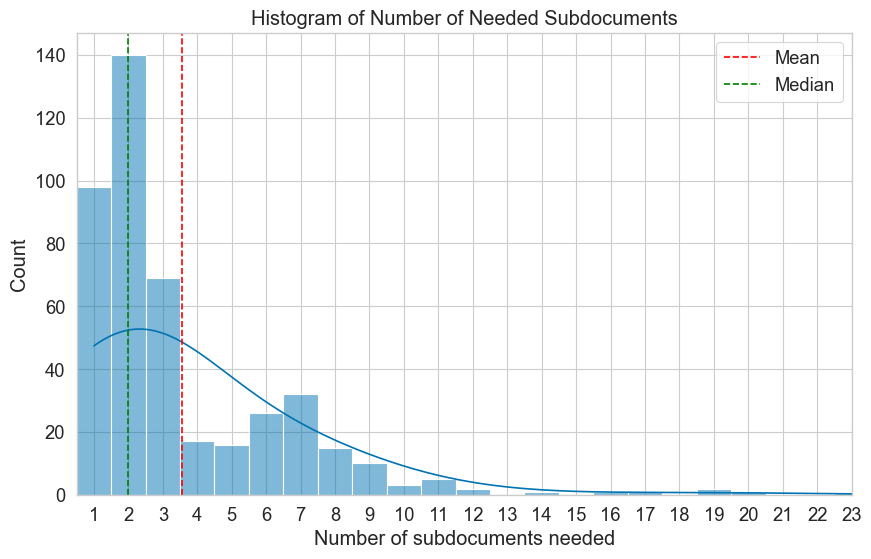

In [30]:
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(10, 6))

x = runs_prediction_stats_df[0]['num_subdocs'].value_counts().sort_index().index
y = runs_prediction_stats_df[0]['num_subdocs'].value_counts().sort_index().values

max_subdocs = max(x)

# add a 0 for each number of subdocs up to the maximum number of subdocs, so that there is a value for each number of subdocs
for i in range(1, max_subdocs+1):
    if i not in x:
        x = np.append(x, i)
        y = np.append(y, 0)

sns.histplot(x=x, weights=y, discrete=True, ax=ax, kde=True)

ax.set(xticks=x)
ax.set_xlim(0.5, max_subdocs)

ax.axvline(x=np.average(x, weights=y), color='red', linestyle='--', label="Mean")

# median calculated manually
z = []
for i in range(len(x)):
    z.extend([x[i]] * y[i])

ax.axvline(x=np.median(z), color='green', linestyle='--', label="Median")

ax.set(xlabel="Number of subdocuments needed")
ax.legend()
ax.set_title("Histogram of Number of Needed Subdocuments")

# plt.subplots_adjust(top=0.5)

plt.show()
fig.savefig(f"plots/{SPLIT}_{MODEL}_subdoc_hist.png", dpi=300)


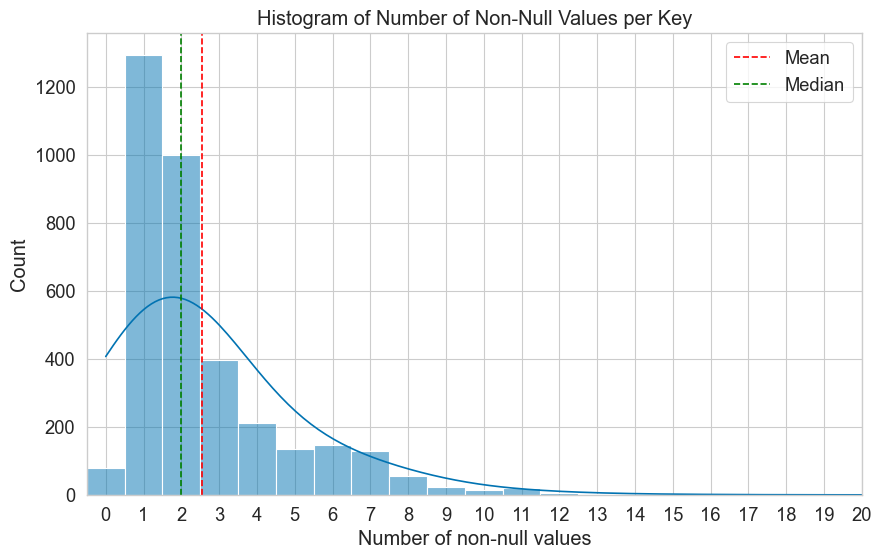

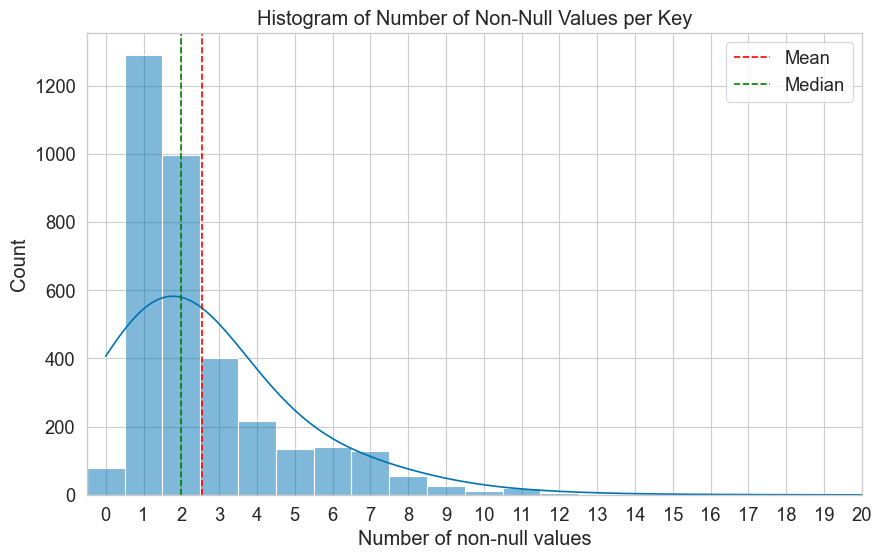

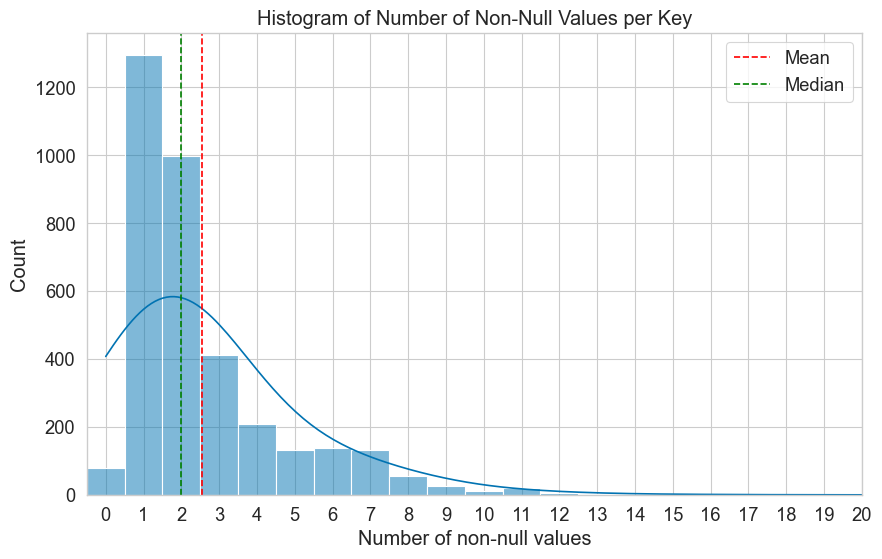

In [31]:
run_counts = []

for run_idx, single_run_prediction_stats_df in enumerate(runs_prediction_stats_df):
    single_run_non_null_values_per_key = {}

    for i in range(len(single_run_prediction_stats_df)):
        for key, value in single_run_prediction_stats_df.iloc[i]['num_non_null_values_per_key'].items():
            if key in single_run_non_null_values_per_key:
                single_run_non_null_values_per_key[key].append(value)
            else:
                single_run_non_null_values_per_key[key] = [value]

    fig, ax = plt.subplots(figsize=(10, 6))

    occurence_dict = {}
    for key, values in single_run_non_null_values_per_key.items():
        for value in values:
            if value in occurence_dict:
                occurence_dict[value] += 1
            else:
                occurence_dict[value] = 1

    # intersperse keys that are missing with value 0
    for i in range(0, max(occurence_dict.keys())+1):
        if i not in occurence_dict:
            occurence_dict[i] = 0

    # sort the dictionary by the key (number of non-null values)
    occurence_dict = dict(sorted(occurence_dict.items(), key=lambda item: item[0]))

    x = list(occurence_dict.keys())
    y = list(occurence_dict.values())

    run_counts.append(y)

    sns.histplot(x=x, weights=y, discrete=True, ax=ax, kde=True)

    ax.axvline(x=np.average(x, weights=y), color='red', linestyle='--', label="Mean")

    # median calculated manually
    z = []
    for i in range(len(x)):
        z.extend([x[i]] * y[i])

    ax.axvline(x=np.median(z), color='green', linestyle='--', label="Median")

    ax.set(xticks=x)
    ax.set_xlim(-0.5, max(x))
    ax.set(xlabel="Number of non-null values")
    ax.set_title("Histogram of Number of Non-Null Values per Key")
    ax.legend()

    plt.show()
    fig.savefig(f"plots/{SPLIT}_{MODEL}_{TEMPERATURE}_RUN{run_idx}_non_null_values_vs_occurence.png", dpi=300)

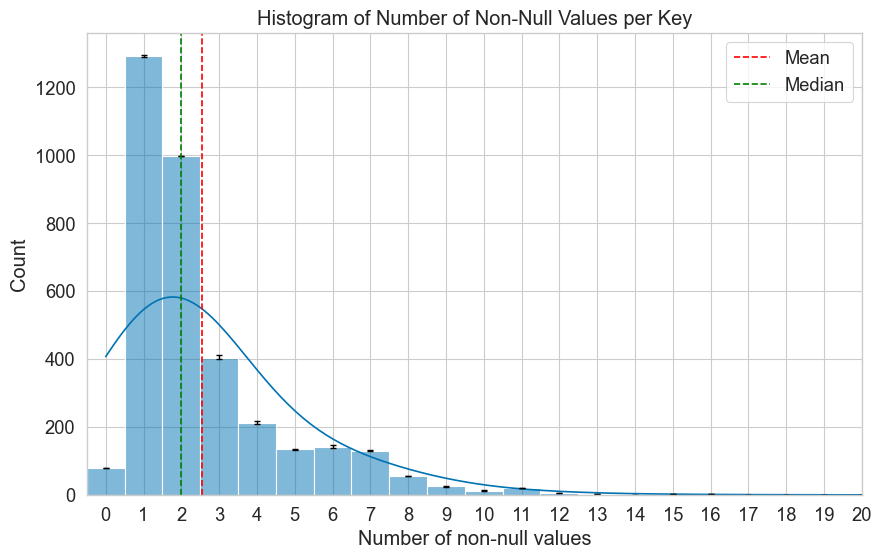

In [32]:
# combine the run_counts into one list
average_counts = []
ranges = [] # for the error bars
# the runs don't necessarily have the same length
# so we need to find the maximum length
max_length = max([len(counts) for counts in run_counts])

for i in range(max_length):
    counts = []
    for run_count in run_counts:
        if i < len(run_count):
            counts.append(run_count[i])
    average_counts.append(np.average(counts))
    ranges.append((np.min(counts), np.max(counts)))

ranges = np.array(ranges).T

# subtract the minimum from the averages (lower error)
ranges[0] = average_counts - ranges[0]

# add the maximum to the averages (upper error)
ranges[1] = ranges[1] - average_counts

fig, ax = plt.subplots(figsize=(10, 6))

x = list(range(len(average_counts)))

sns.histplot(x=x, weights=average_counts, discrete=True, ax=ax, kde=True)

# error bars
ax.errorbar(x, average_counts, yerr=ranges, fmt='none', ecolor='black', elinewidth=1, capsize=2)

# mean
ax.axvline(x=np.average(x, weights=average_counts), color='red', linestyle='--', label="Mean")

# median calculated manually
z = []
for i in range(len(x)):
    z.extend([x[i]] * round(average_counts[i]))

ax.axvline(x=np.median(z), color='green', linestyle='--', label="Median")

ax.set(xticks=x)
ax.set_xlim(-0.5, max(x))
ax.set(xlabel="Number of non-null values")
ax.set_title("Histogram of Number of Non-Null Values per Key")
ax.legend()
plt.show()
fig.savefig(f"plots/{SPLIT}_{MODEL}_{TEMPERATURE}_average_non_null_values_vs_occurence.png", dpi=300)

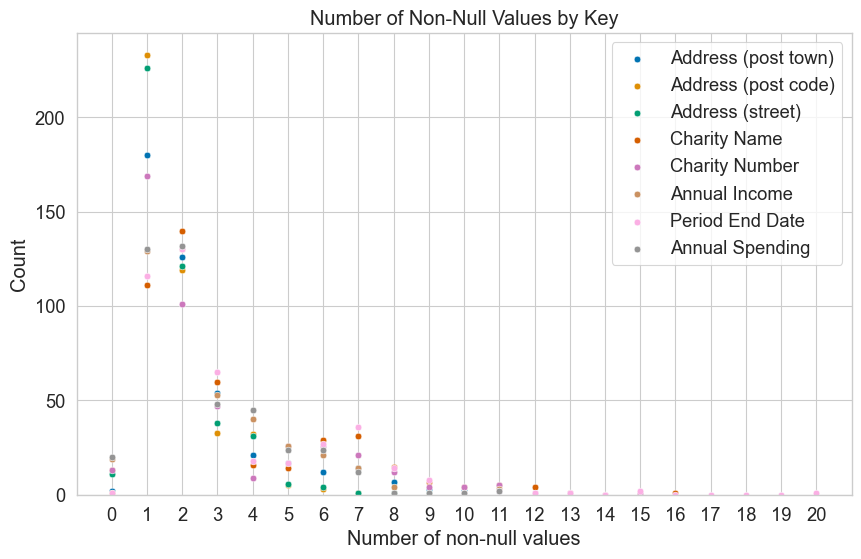

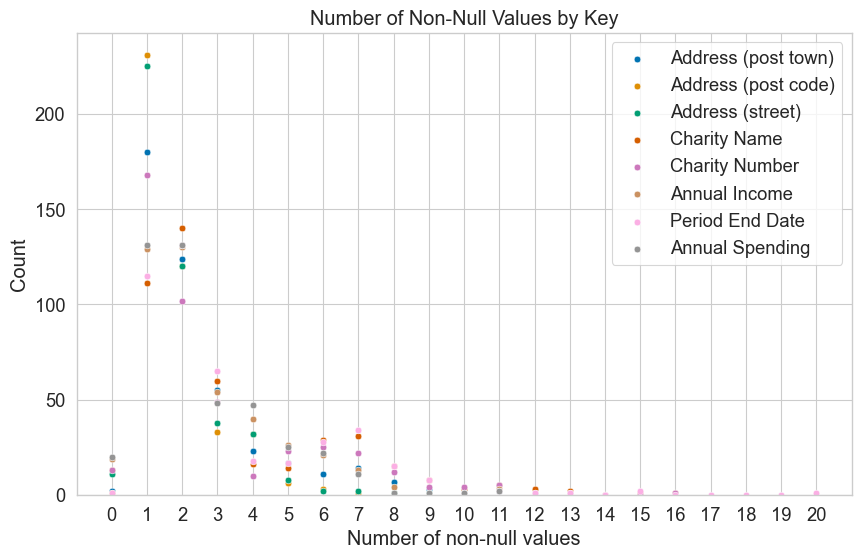

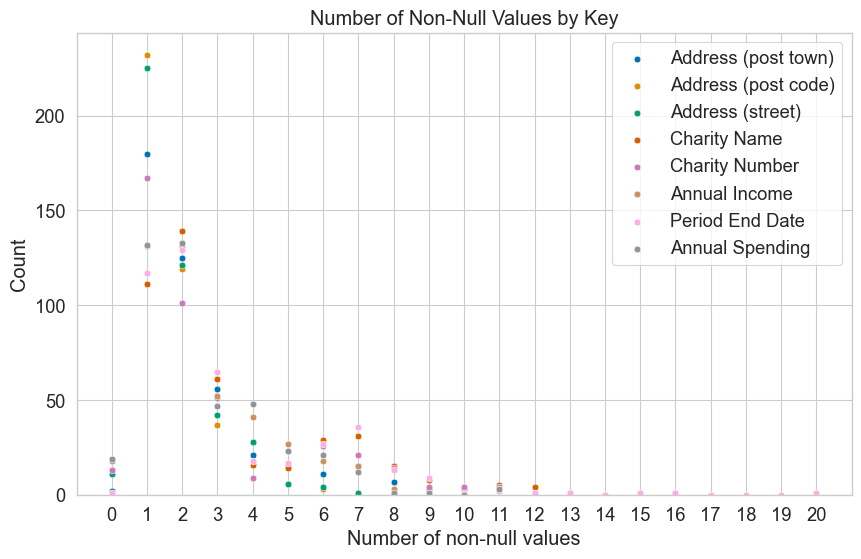

In [33]:
runs_non_null_values_by_key = []

for run_idx, single_run_prediction_stats_df in enumerate(runs_prediction_stats_df):

    non_null_values_by_key = {}

    for i in range(len(single_run_prediction_stats_df)):
        for key, value in single_run_prediction_stats_df.iloc[i]['num_non_null_values_per_key'].items():
            if key in non_null_values_by_key:
                non_null_values_by_key[key].append(value)
            else:
                non_null_values_by_key[key] = [value]

    fig, ax = plt.subplots(figsize=(10, 6))

    # one key = one scatter plot
    max_val = 0
    for key, values in non_null_values_by_key.items():
        occurence_dict = {}
        for value in values:
            if value in occurence_dict:
                occurence_dict[value] += 1
            else:
                occurence_dict[value] = 1

        # intersperse keys that are missing with value 0
        for i in range(0, max(occurence_dict.keys())+1):
            if i not in occurence_dict:
                occurence_dict[i] = 0

        # sort the dictionary by the key (number of unifications)
        occurence_dict = dict(sorted(occurence_dict.items(), key=lambda item: item[0]))

        x = list(occurence_dict.keys())
        y = list(occurence_dict.values())
        
        ax = sns.scatterplot(x=x, y=y, ax=ax, label=key)
        max_val = max(max_val, max(x))

    runs_non_null_values_by_key.append(non_null_values_by_key)

    ax.set(xlabel="Number of non-null values", ylabel="Count")

    # set the x-ticks to be integers
    ax.set_xticks(np.arange(0, max_val+1, 1))
    
    ax.set_ylim(0,)
    ax.legend()
    ax.set_title("Number of Non-Null Values by Key")

    plt.show()
    fig.savefig(f"plots/{SPLIT}_{MODEL}_{TEMPERATURE}_RUN{run_idx}_non_null_values_by_key_vs_count.png", dpi=300)


/Users/ivo/Library/Caches/pypoetry/virtualenvs/uni-kie-JrmAaldC-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ivo/Library/Caches/pypoetry/virtualenvs/uni-kie-JrmAaldC-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


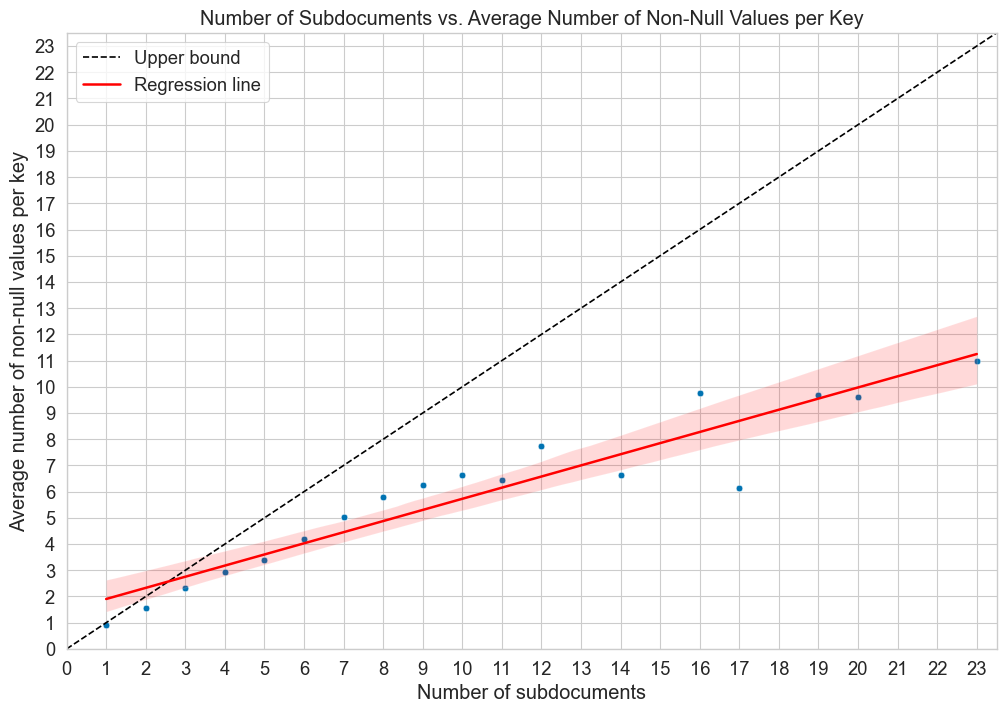

Correlation coefficient: 0.945


/Users/ivo/Library/Caches/pypoetry/virtualenvs/uni-kie-JrmAaldC-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ivo/Library/Caches/pypoetry/virtualenvs/uni-kie-JrmAaldC-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


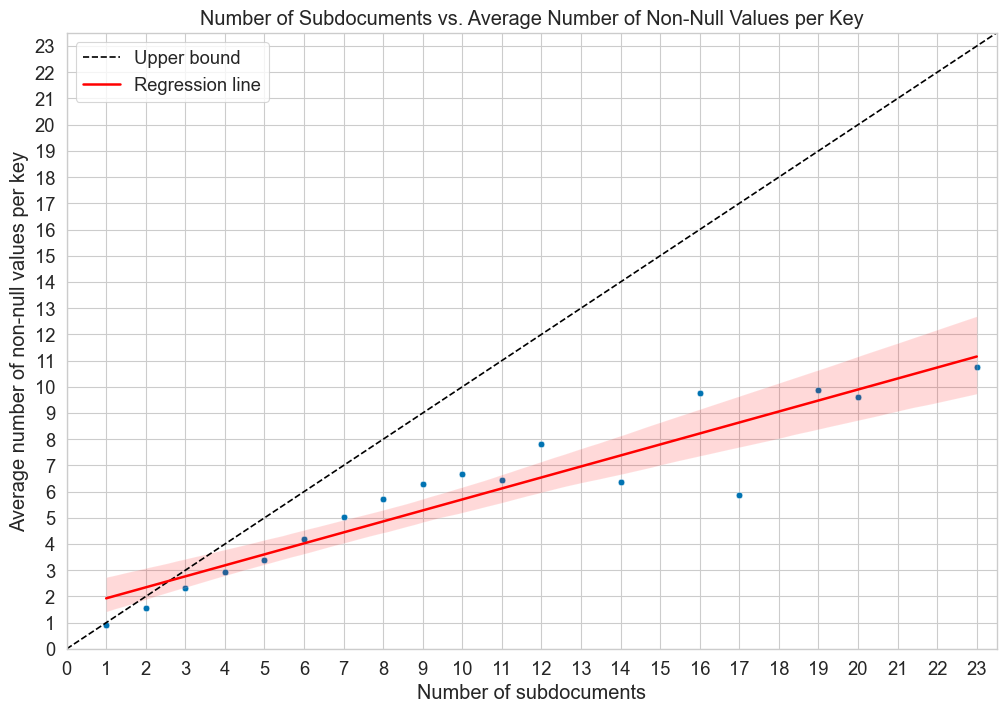

Correlation coefficient: 0.937


/Users/ivo/Library/Caches/pypoetry/virtualenvs/uni-kie-JrmAaldC-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ivo/Library/Caches/pypoetry/virtualenvs/uni-kie-JrmAaldC-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


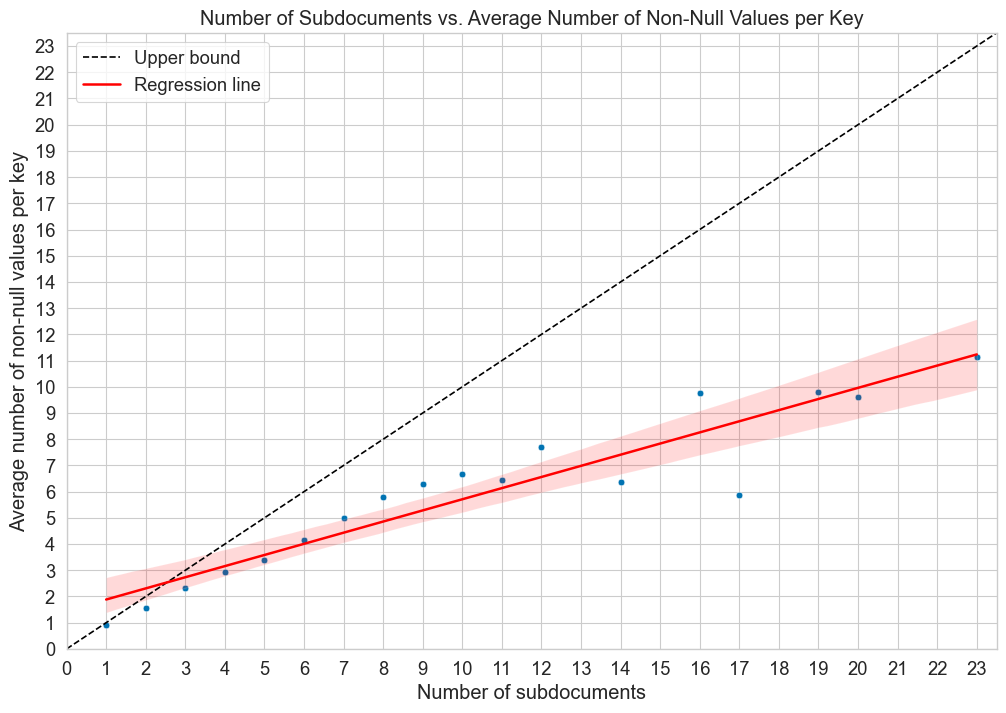

Correlation coefficient: 0.94


In [34]:
runs_y = []

for run_idx, single_run_prediction_stats_df in enumerate(runs_prediction_stats_df):

    fig, ax = plt.subplots(figsize=(12, 8))

    max_subdocs = max(single_run_prediction_stats_df['num_subdocs'])

    x = np.arange(0, max_subdocs+1)
    y = [] # number of non-null values per key (average over all keys)

    y = [[] for _ in range(max(x)+1)]

    for i in range(len(single_run_prediction_stats_df)):
        num_subdocs = single_run_prediction_stats_df.iloc[i]['num_subdocs']


        num_non_null_values = 0
        num_keys = 0
        for key, value in single_run_prediction_stats_df.iloc[i]['num_non_null_values_per_key'].items():
            num_non_null_values += value
            num_keys += 1
        if num_keys > 0:
            y[num_subdocs].append(num_non_null_values / num_keys)
        else:
            y[num_subdocs].append(0)

    y = [np.mean(y[i]) for i in range(len(y))] # average number of non-null values per key for each number of subdocuments

    runs_y.append(y)

    ax.plot([0, max(x) + 1], [0, max(x) + 1], color='black', linestyle='--', label='Upper bound')

    ax = sns.scatterplot(x=x, y=y, ax=ax)

    sns.regplot(x=x, y=y, ax=ax, scatter=False, color='red', label='Regression line')

    ax.set(xticks=x, yticks=x)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.set_xlim(right=max_subdocs+0.5)
    ax.set_ylim(top=max_subdocs+0.5)

    # remove nan values from x and y
    x = [x[i] for i in range(len(x)) if not np.isnan(y[i])]
    y = [y[i] for i in range(len(y)) if not np.isnan(y[i])]


    ax.set(xlabel="Number of subdocuments", ylabel="Average number of non-null values per key")
    ax.legend(loc='upper left')
    ax.set_title("Number of Subdocuments vs. Average Number of Non-Null Values per Key")

    plt.show()
    fig.savefig(f"plots/{SPLIT}_{MODEL}_{TEMPERATURE}_RUN{run_idx}_num_subdocs_vs_non_null_values_per_key.png", dpi=300)

    print("Correlation coefficient: " + str(round(np.corrcoef(x, y)[0, 1], 3)))


Correlation coefficient: 0.941


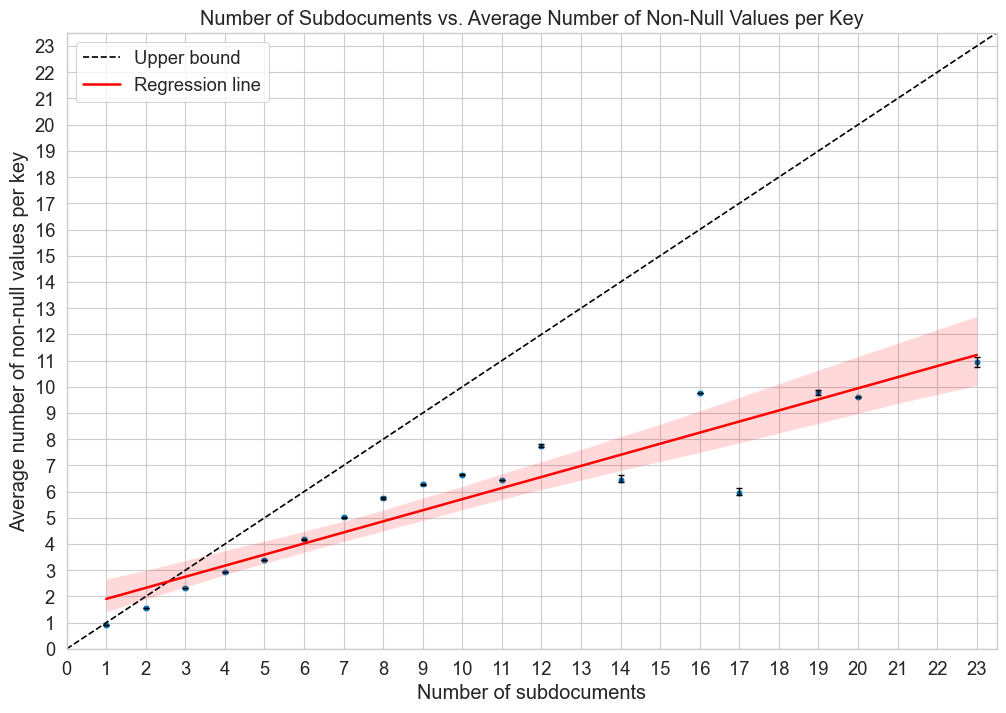

In [35]:
# plot the average of all runs with error bars
fig, ax = plt.subplots(figsize=(12, 8))

max_subdocs = max(runs_prediction_stats_df[0]['num_subdocs'])

x = np.arange(0, max_subdocs+1)

# y is now the average over the runs in runs_y
y = [np.mean([runs_y[run_idx][i] for run_idx in range(len(runs_y))]) for i in range(len(runs_y[0]))]

# yerr is the min and max of the runs in runs_y subtracted (for min) and added (for max)
yerr = [[y[i] - min([runs_y[run_idx][i] for run_idx in range(len(runs_y))]) for i in range(len(runs_y[0]))], [max([runs_y[run_idx][i] for run_idx in range(len(runs_y))]) - y[i] for i in range(len(runs_y[0]))]]

ax.plot([0, max(x) + 1], [0, max(x) + 1], color='black', linestyle='--', label='Upper bound')

ax = sns.scatterplot(x=x, y=y, ax=ax)

# error bars
ax.errorbar(x, y, yerr=yerr, fmt='none', ecolor='black', elinewidth=1, capsize=2)


sns.regplot(x=x, y=y, ax=ax, scatter=False, color='red', label='Regression line')

ax.set(xticks=x, yticks=x)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_xlim(right=max_subdocs+0.5)
ax.set_ylim(top=max_subdocs+0.5)

# remove nan values from x and y
x = [x[i] for i in range(len(x)) if not np.isnan(y[i])]
y = [y[i] for i in range(len(y)) if not np.isnan(y[i])]


ax.set(xlabel="Number of subdocuments", ylabel="Average number of non-null values per key")
ax.legend(loc='upper left')
ax.set_title("Number of Subdocuments vs. Average Number of Non-Null Values per Key")

print("Correlation coefficient: " + str(round(np.corrcoef(x, y)[0, 1], 3)))


plt.show()
fig.savefig(f"plots/{SPLIT}_{MODEL}_{TEMPERATURE}_average_num_subdocs_vs_non_null_values_per_key.png", dpi=300)


In [36]:
runs_key_stats = []

for run_idx, non_null_values_by_key in enumerate(runs_non_null_values_by_key):

    x = []
    y = []

    for key, values in non_null_values_by_key.items():
        x.append(key)
        y.append(sum(values)/len(values))

    y = [round(y[i], 3) for i in range(len(y))]

    key_stats = pd.DataFrame({'key': x, 'avg_num_of_non_null_values': y})
    runs_key_stats.append(key_stats)

    print(f"RUN{run_idx}")
    print(key_stats) # avg_num_of_non_null_values is the average number of non-null values per key
    print(runs_lenient_accuracy_by_key[run_idx]) # lenient_accuracy_by_key is the accuracy for each key

RUN0
                   key  avg_num_of_non_null_values
0  Address (post town)                       2.405
1  Address (post code)                       1.718
2     Address (street)                       1.782
3         Charity Name                       3.332
4       Charity Number                       2.836
5        Annual Income                       2.584
6      Period End Date                       3.257
7      Annual Spending                       2.534
   Address (post town)  Address (post code)  Address (street)  Charity Name  \
0             0.788636             0.702273          0.384091      0.620455   

   Charity Number  Annual Income  Period End Date  Annual Spending  
0        0.945455          0.575         0.963636         0.588636  
RUN1
                   key  avg_num_of_non_null_values
0  Address (post town)                       2.407
1  Address (post code)                       1.730
2     Address (street)                       1.795
3         Charity Name        

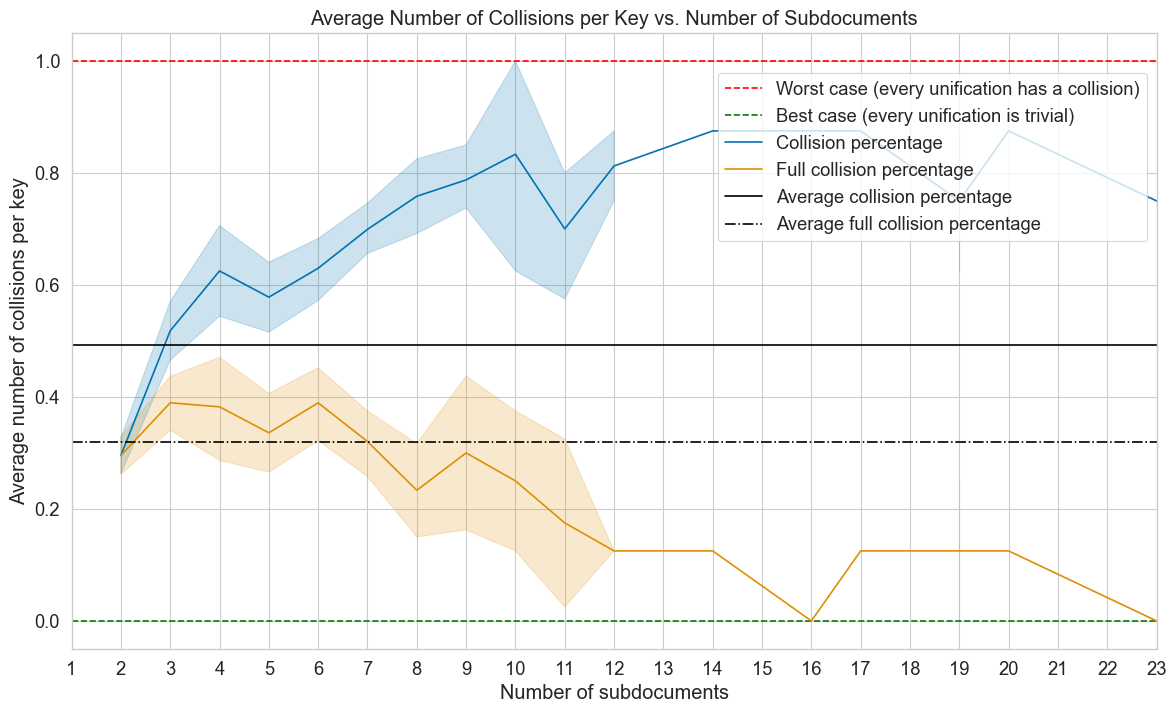

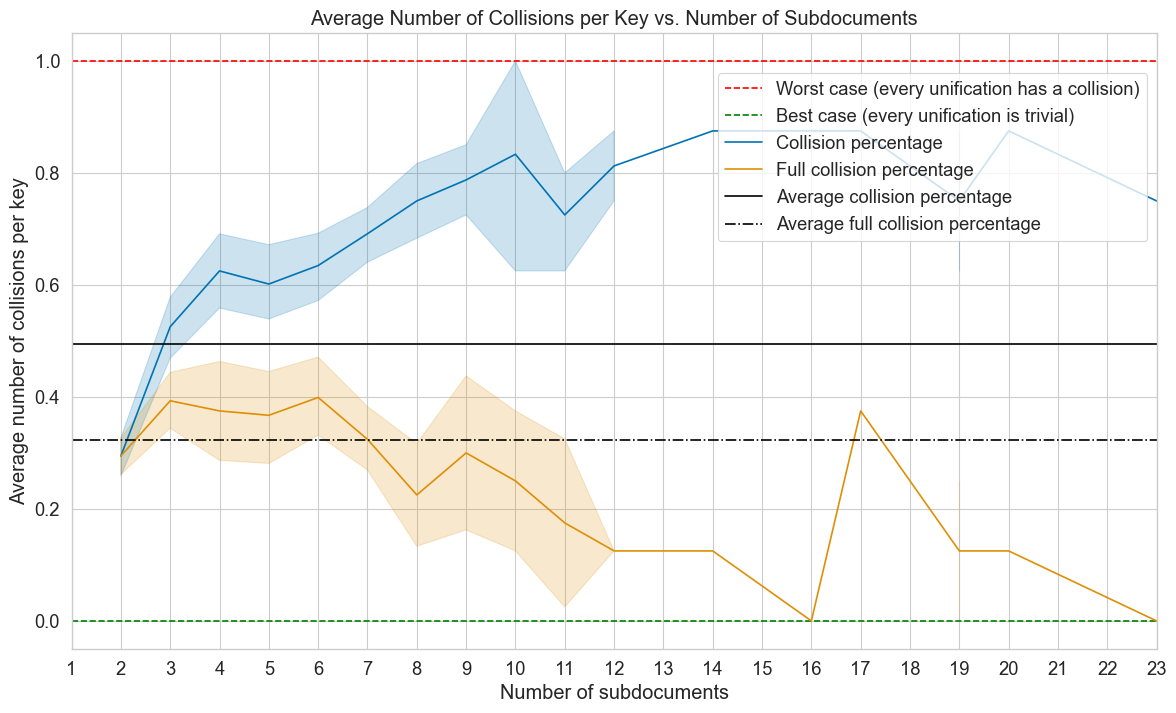

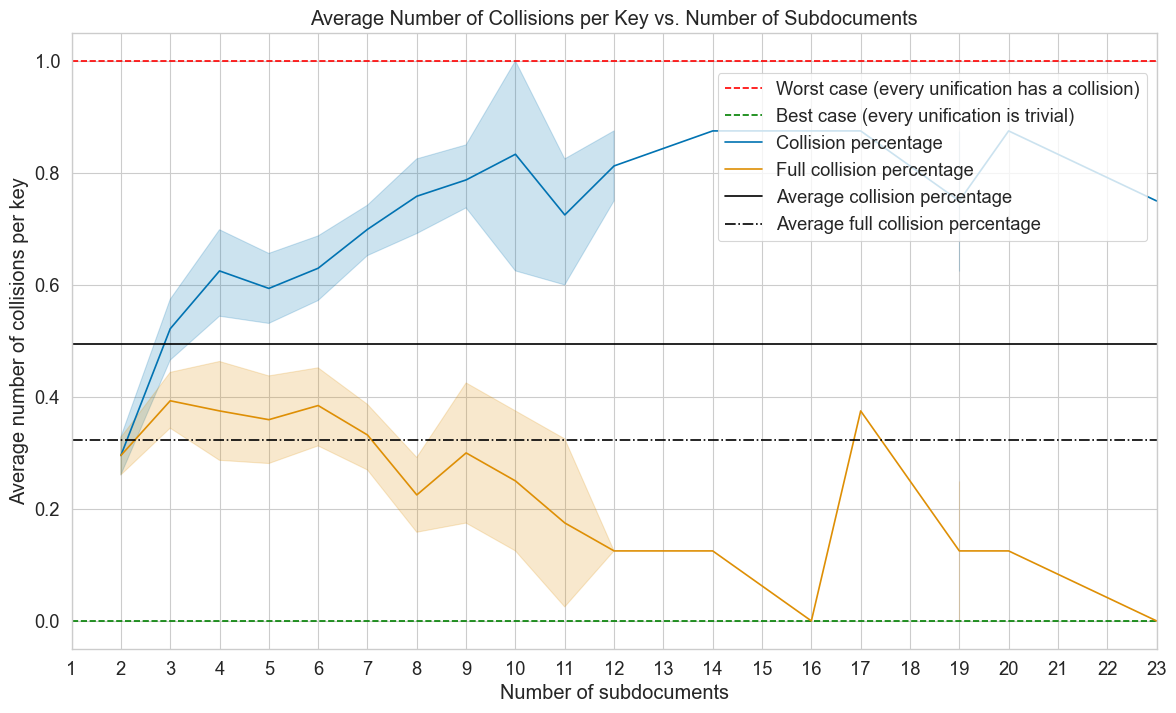

In [37]:
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

for run_idx, single_run_prediction_stats_df in enumerate(runs_prediction_stats_df):
    fig, ax = plt.subplots(figsize=(14, 8))

    ax.axhline(y=1, color="red", linestyle="--", label="Worst case (every unification has a collision)")
    ax.axhline(y=0, color="green", linestyle="--", label="Best case (every unification is trivial)")

    
    ax = sns.lineplot(x="num_subdocs", y="collision_percentage", data=single_run_prediction_stats_df, ax=ax, label="Collision percentage")
    
    ax = sns.lineplot(x="num_subdocs", y="full_collision_percentage", data=single_run_prediction_stats_df, ax=ax, label="Full collision percentage")

    avg_collision_percentage = np.nanmean(single_run_prediction_stats_df['collision_percentage'])
    ax.axhline(y=avg_collision_percentage, color="black", linestyle="-", label="Average collision percentage")

    avg_full_collision_percentage = np.nanmean(single_run_prediction_stats_df['full_collision_percentage'])
    ax.axhline(y=avg_full_collision_percentage, color="black", linestyle="-.", label="Average full collision percentage")

    ax.set_xlim(left=1, right=max(single_run_prediction_stats_df['num_subdocs']))
    ax.set(xticks=np.arange(1, max_subdocs+1, 1))
    ax.set(xlabel="Number of subdocuments", ylabel="Average number of collisions per key", title="Average Number of Collisions per Key vs. Number of Subdocuments")
    ax.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))

    plt.show()

    fig.savefig(f"plots/{SPLIT}_{MODEL}_{TEMPERATURE}_RUN{run_idx}_collisions_wrt_subdocs_hist.png", dpi=300)

In [38]:
combined_runs_prediction_stats_df = pd.concat(runs_prediction_stats_df, ignore_index=True)

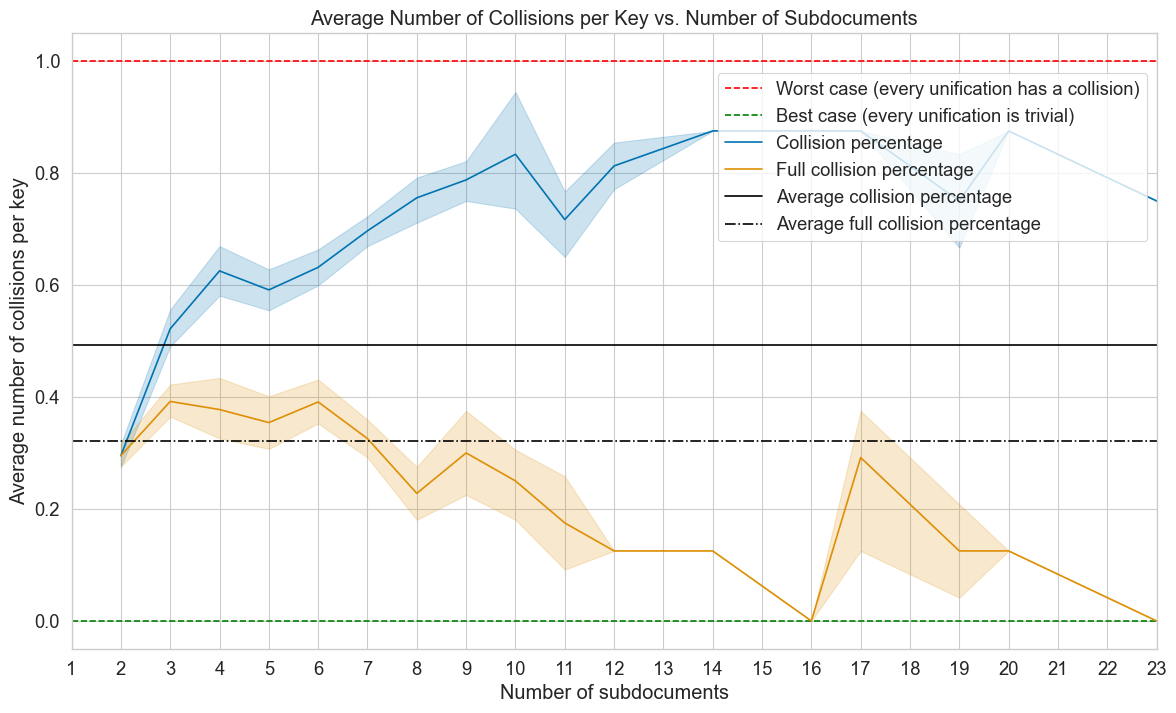

In [39]:
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(14, 8))

ax.axhline(y=1, color="red", linestyle="--", label="Worst case (every unification has a collision)")
ax.axhline(y=0, color="green", linestyle="--", label="Best case (every unification is trivial)")


ax = sns.lineplot(x="num_subdocs", y="collision_percentage", data=combined_runs_prediction_stats_df, ax=ax, label="Collision percentage")

ax = sns.lineplot(x="num_subdocs", y="full_collision_percentage", data=combined_runs_prediction_stats_df, ax=ax, label="Full collision percentage")

avg_collision_percentage = np.nanmean(combined_runs_prediction_stats_df['collision_percentage'])
ax.axhline(y=avg_collision_percentage, color="black", linestyle="-", label="Average collision percentage")

avg_full_collision_percentage = np.nanmean(combined_runs_prediction_stats_df['full_collision_percentage'])
ax.axhline(y=avg_full_collision_percentage, color="black", linestyle="-.", label="Average full collision percentage")

ax.set_xlim(left=1, right=max(combined_runs_prediction_stats_df['num_subdocs']))
ax.set(xticks=np.arange(1, max_subdocs+1, 1))
ax.set(xlabel="Number of subdocuments", ylabel="Average number of collisions per key", title="Average Number of Collisions per Key vs. Number of Subdocuments")
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))

plt.show()

fig.savefig(f"plots/{SPLIT}_{MODEL}_{TEMPERATURE}_average_collisions_wrt_subdocs_hist.png", dpi=300)

1 subdocument == no subdocs (or in other words: the 1 subdoc is the whole document)

Note: best case assumes:
* perfect OCR
* no mistakes in the reports (no typos, no conflicting information on different pages)

of course with num_subdocs=2 every collision is also a full_collision :) 

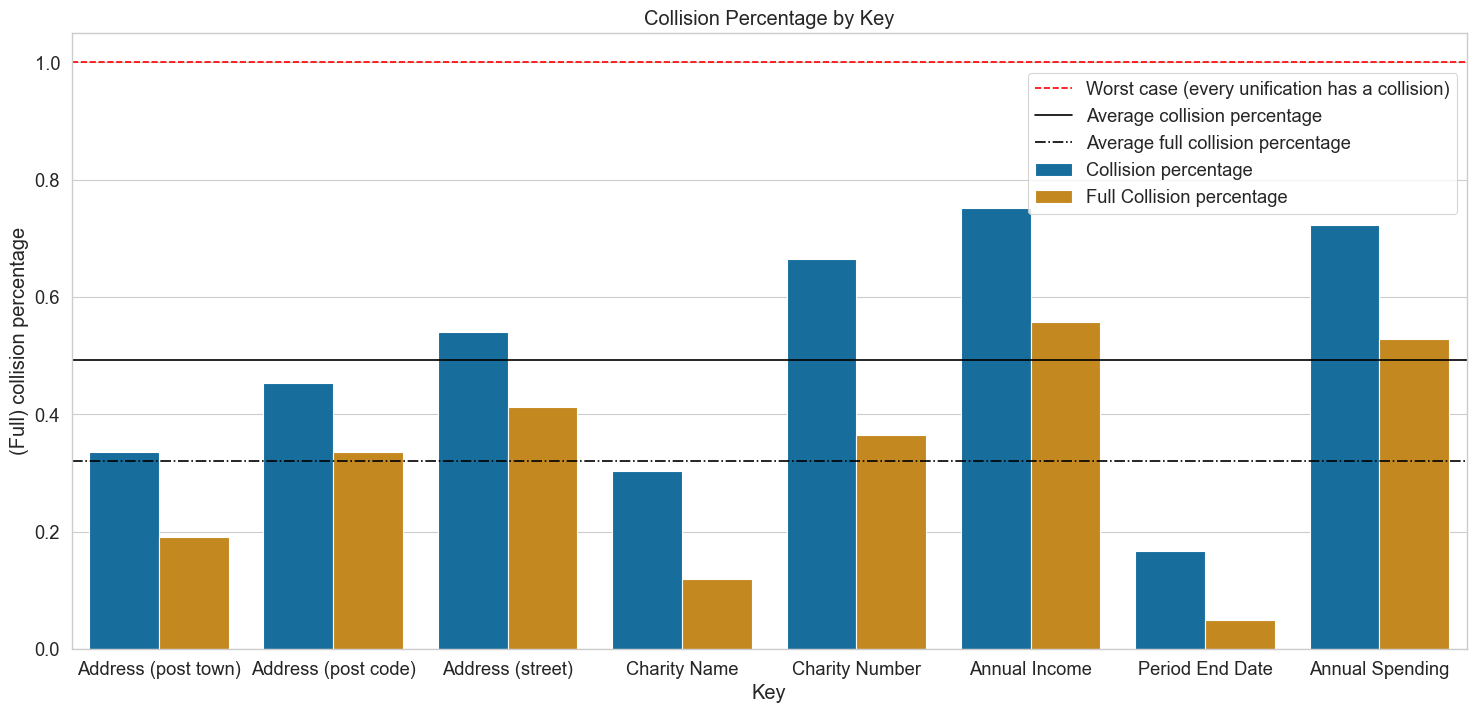

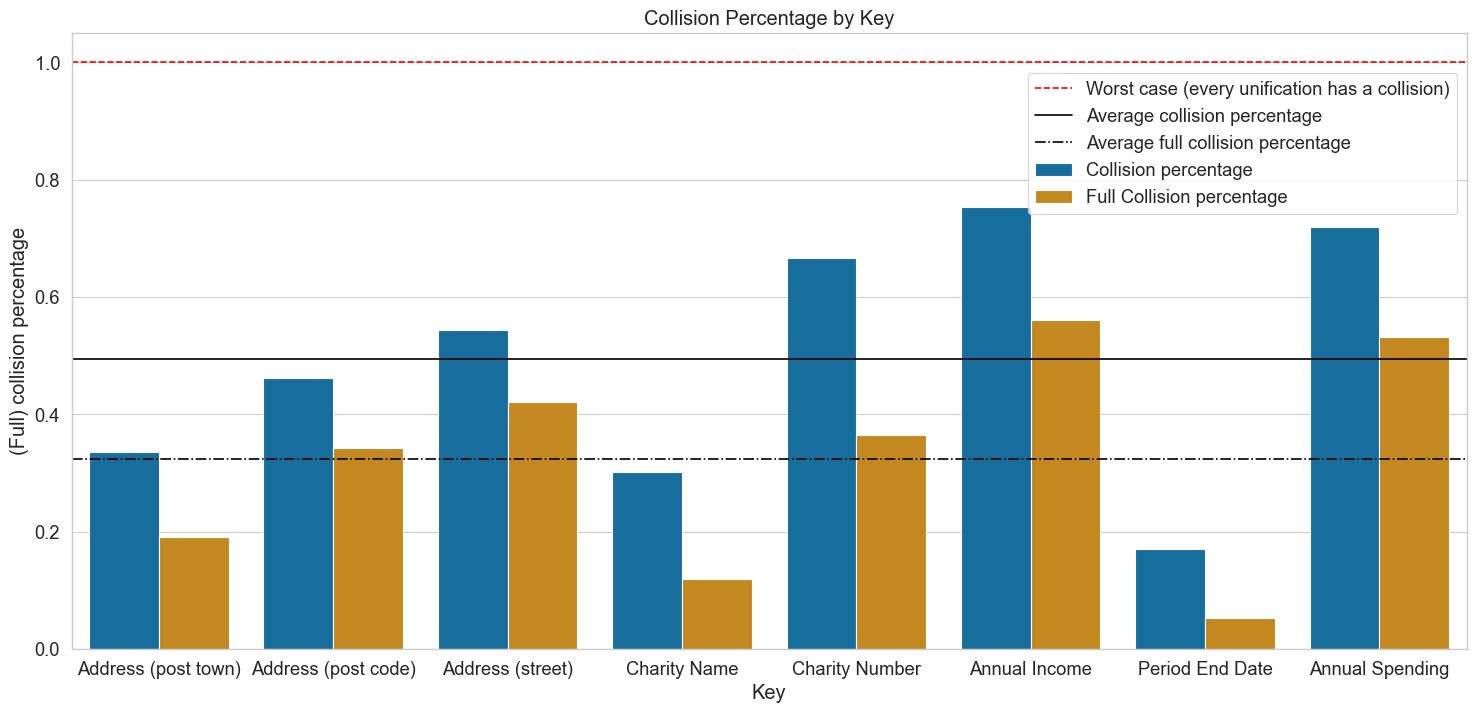

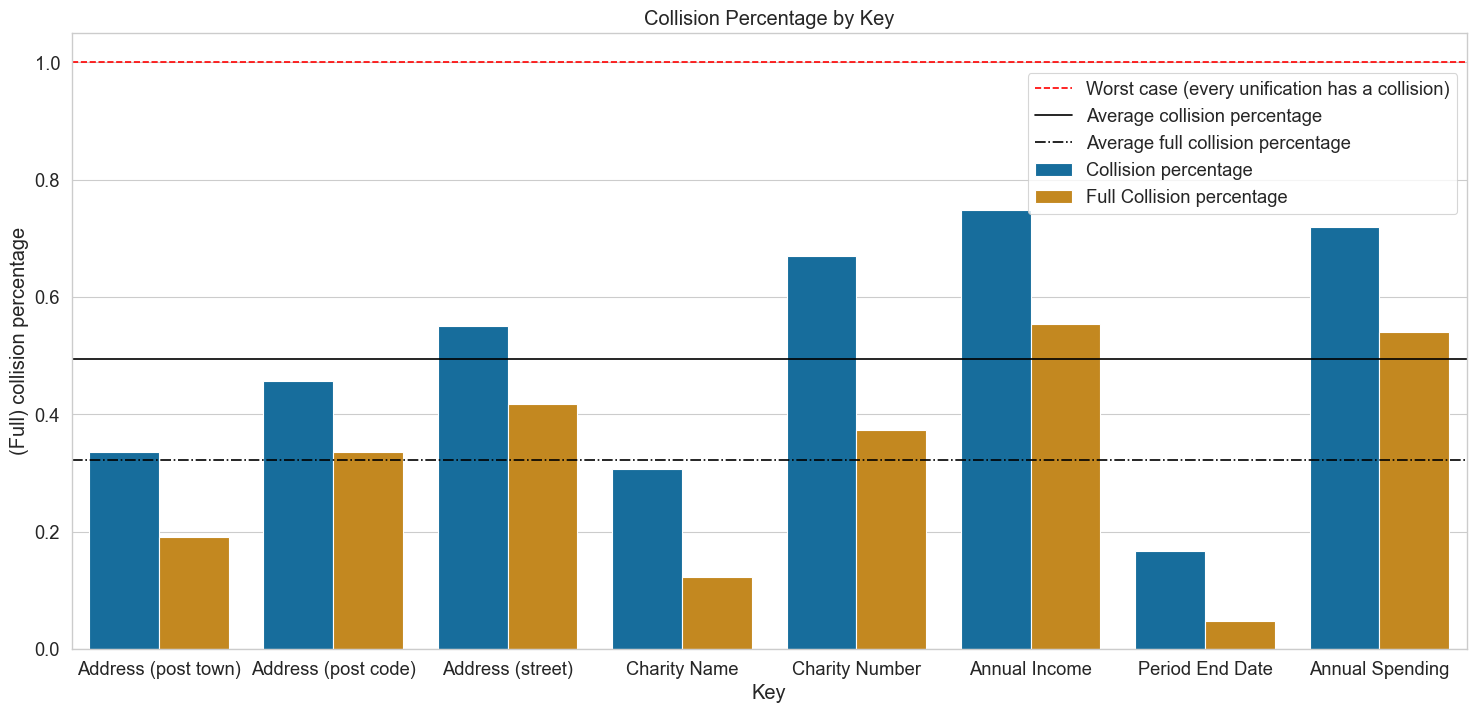

In [40]:
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

runs_key_stats_trf = []
runs_avg_collision_percentage = []
runs_avg_full_collision_percentage = []

for run_idx, single_run_prediction_stats_df in enumerate(runs_prediction_stats_df):
    fig, ax = plt.subplots(figsize=(18, 8))

    ax.axhline(y=1, color="red", linestyle="--", label="Worst case (every unification has a collision)")

    collision_percentage_by_key = {}
    full_collision_percentage_by_key = {}


    for key in single_run_prediction_stats_df['num_unified_values_per_key'].iloc[0].keys():
        for i in range(len(single_run_prediction_stats_df)):
            if key not in collision_percentage_by_key:
                collision_percentage_by_key[key] = []

            if key not in full_collision_percentage_by_key:
                full_collision_percentage_by_key[key] = []

            collision_percentage_by_key[key].append(single_run_prediction_stats_df['collision_per_key'].iloc[i][key])
            full_collision_percentage_by_key[key].append(single_run_prediction_stats_df['full_collision_per_key'].iloc[i][key])

    # filter out None values
    collision_percentage_by_key = {key: [x for x in collision_percentage_by_key[key] if x is not None] for key in collision_percentage_by_key.keys()}
    full_collision_percentage_by_key = {key: [x for x in full_collision_percentage_by_key[key] if x is not None] for key in full_collision_percentage_by_key.keys()}

    # calculate average and ignore nan values and round to 3 decimal places
    collision_percentage_by_key = {key: round(np.nanmean(collision_percentage_by_key[key]), 3) for key in collision_percentage_by_key.keys()}
    full_collision_percentage_by_key = {key: round(np.nanmean(full_collision_percentage_by_key[key]), 3) for key in full_collision_percentage_by_key.keys()}

    # add those values to the dataframe
    runs_key_stats[run_idx]['collision_percentage'] = runs_key_stats[run_idx]['key'].map(collision_percentage_by_key)
    runs_key_stats[run_idx]['full_collision_percentage'] = runs_key_stats[run_idx]['key'].map(full_collision_percentage_by_key)

    # create a barplot that has grouped bars

    # we want to use the "hue" parameter to group the bars by collision vs. full collision
    # thus we have to transform the dataframe to have a column for each of the two types of collisions
    # and a column for the key
    key_stats_trf = runs_key_stats[run_idx].melt(id_vars=['key'], value_vars=['collision_percentage', 'full_collision_percentage'], var_name='collision_type', value_name='collision_pct')

    # rename the collision types to something more readable
    key_stats_trf['collision_type'] = key_stats_trf['collision_type'].map({'collision_percentage': 'Collision percentage', 'full_collision_percentage': 'Full Collision percentage'})

    runs_key_stats_trf.append(key_stats_trf)

    # create the barplot
    ax = sns.barplot(x="key", y="collision_pct", hue="collision_type", data=key_stats_trf, ax=ax)

    avg_collision_percentage = np.nanmean(list(collision_percentage_by_key.values()))
    ax.axhline(y=avg_collision_percentage, color="black", linestyle="-", label="Average collision percentage")
    runs_avg_collision_percentage.append(avg_collision_percentage)

    avg_full_collision_percentage = np.nanmean(list(full_collision_percentage_by_key.values()))
    ax.axhline(y=avg_full_collision_percentage, color="black", linestyle="-.", label="Average full collision percentage")
    runs_avg_full_collision_percentage.append(avg_full_collision_percentage)

    ax.set(xlabel="Key", ylabel="(Full) collision percentage", title="Collision Percentage by Key")
    ax.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))

    plt.show()
    fig.savefig(f"plots/{SPLIT}_{MODEL}_{TEMPERATURE}_RUN{run_idx}_collision_percentage_by_key.png", dpi=300)

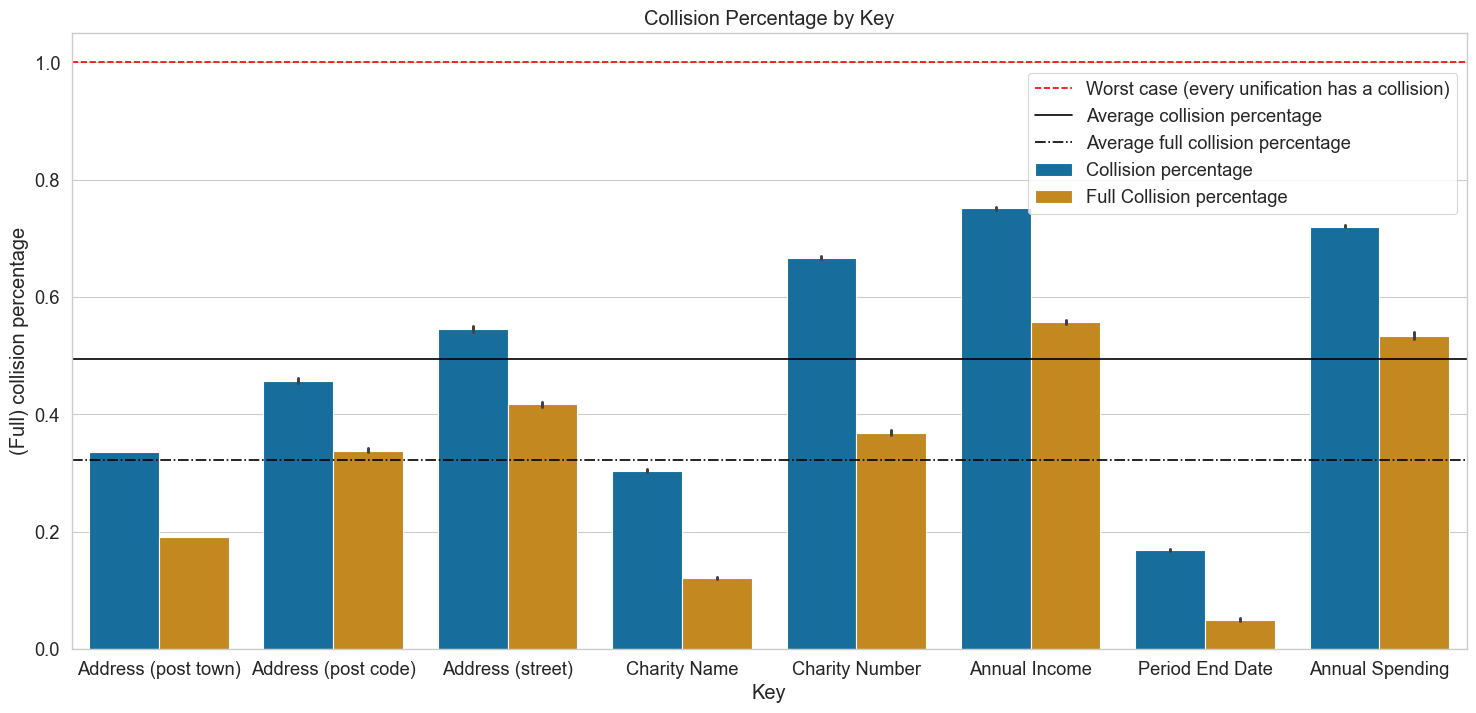

In [41]:
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(18, 8))

ax.axhline(y=1, color="red", linestyle="--", label="Worst case (every unification has a collision)")

ax = sns.barplot(x="key", y="collision_pct", hue="collision_type", data=pd.concat(runs_key_stats_trf), ax=ax, errorbar=("pi", 100))
avg_collision_percentage = np.nanmean(runs_avg_collision_percentage)
ax.axhline(y=avg_collision_percentage, color="black", linestyle="-", label="Average collision percentage")
runs_avg_collision_percentage.append(avg_collision_percentage)

avg_full_collision_percentage = np.nanmean(runs_avg_full_collision_percentage)
ax.axhline(y=avg_full_collision_percentage, color="black", linestyle="-.", label="Average full collision percentage")
runs_avg_full_collision_percentage.append(avg_full_collision_percentage)

ax.set(xlabel="Key", ylabel="(Full) collision percentage", title="Collision Percentage by Key")
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))

plt.show()
fig.savefig(f"plots/{SPLIT}_{MODEL}_{TEMPERATURE}_average_collision_percentage_by_key.png", dpi=300)

In [42]:
# calculate the ratio of full collision percentage to collision percentage for each run and key and attach it as a column to the dataframe
for run_idx in range(len(runs_key_stats)):
    runs_key_stats[run_idx]['full_collision_over_collision'] = round(runs_key_stats[run_idx]['full_collision_percentage'] / runs_key_stats[run_idx]['collision_percentage'], 3)

In [43]:
combined_runs_key_stats = pd.concat(runs_key_stats)
combined_runs_lenient_accuracy_by_key = pd.concat(runs_lenient_accuracy_by_key)
combined_own_evaluation_by_key = pd.concat([own_evaluation.mean(axis=0, skipna=True) for own_evaluation in own_evaluations], axis=1)
combined_runs_accuracies_by_key = pd.concat(runs_accuracies_by_key)

In [44]:
combined_runs_lenient_accuracy_by_key.reset_index(drop=True, inplace=True)
combined_runs_lenient_accuracy_by_key = combined_runs_lenient_accuracy_by_key.T

# put the columns below each other (instead of next to each other)
combined_runs_lenient_accuracy_by_key = combined_runs_lenient_accuracy_by_key.stack().reset_index()
combined_runs_lenient_accuracy_by_key.columns = ['key', 'run', 'lenient_accuracy']

# copy the index into a column
combined_runs_lenient_accuracy_by_key['index'] = combined_runs_lenient_accuracy_by_key.index

# change the order so that the keys of a single run are next to each other. sort by run and then by index of the row (not a real column)
combined_runs_lenient_accuracy_by_key = combined_runs_lenient_accuracy_by_key.sort_values(['run', 'index']).reset_index(drop=True)

# drop the index column
combined_runs_lenient_accuracy_by_key.drop(columns=['index'], inplace=True)


In [45]:
# put the columns below each other (instead of next to each other)
combined_own_evaluation_by_key = combined_own_evaluation_by_key.stack().reset_index()

# rename the columns
combined_own_evaluation_by_key.columns = ['key', 'run', 'score']

# copy the index into a column
combined_own_evaluation_by_key['index'] = combined_own_evaluation_by_key.index

# change the order so that the keys of a single run are next to each other. sort by run and then by index of the row (not a real column)
combined_own_evaluation_by_key = combined_own_evaluation_by_key.sort_values(['run', 'index']).reset_index(drop=True)

# drop the index column
combined_own_evaluation_by_key.drop(columns=['index'], inplace=True)

## Some correlations

In [46]:
print("[By key] Correlation coefficient between avg_num_of_non_null_values and collision percentage: " + str(round(np.corrcoef(combined_runs_key_stats['avg_num_of_non_null_values'], combined_runs_key_stats['collision_percentage'])[0, 1], 3)))
print("--------------------")

print("[By key] Correlation coefficient between avg_num_of_non_null_values and (own) accuracy: " + str(round(np.corrcoef(combined_runs_key_stats['avg_num_of_non_null_values'], combined_own_evaluation_by_key['score'])[0, 1], 3)))
print("[By key] Correlation coefficient between avg_num_of_non_null_values and (official) accuracy: " + str(round(np.corrcoef(combined_runs_key_stats['avg_num_of_non_null_values'], combined_runs_accuracies_by_key)[0, 1], 3)))
print("[By key] Correlation coefficient between avg_num_of_non_null_values and (official) lenient accuracy: " + str(round(np.corrcoef(combined_runs_key_stats['avg_num_of_non_null_values'], combined_runs_lenient_accuracy_by_key['lenient_accuracy'])[0, 1], 3)))
print("--------------------")

print("[By key] Correlation coefficient between collision percentage and (own) accuracy: " + str(round(np.corrcoef(combined_runs_key_stats['collision_percentage'], combined_own_evaluation_by_key['score'])[0, 1], 3)))
print("[By key] Correlation coefficient between collision percentage and (official) accuracy: " + str(round(np.corrcoef(combined_runs_key_stats['collision_percentage'], combined_runs_accuracies_by_key)[0, 1], 3)))
print("[By key] Correlation coefficient between collision percentage and (official) lenient accuracy: " + str(round(np.corrcoef(combined_runs_key_stats['collision_percentage'], combined_runs_lenient_accuracy_by_key['lenient_accuracy'])[0, 1], 3)))
print("--------------------")

print("[By key] Correlation coefficient between full collision percentage and (own) accuracy: " + str(round(np.corrcoef(combined_runs_key_stats['full_collision_percentage'], combined_own_evaluation_by_key['score'])[0, 1], 3)))
print("[By key] Correlation coefficient between full collision percentage and (official) accuracy: " + str(round(np.corrcoef(combined_runs_key_stats['full_collision_percentage'], combined_runs_accuracies_by_key)[0, 1], 3)))
print("[By key] Correlation coefficient between full collision percentage and (official) lenient accuracy: " + str(round(np.corrcoef(combined_runs_key_stats['full_collision_percentage'], combined_runs_lenient_accuracy_by_key['lenient_accuracy'])[0, 1], 3)))
print("--------------------")

[By key] Correlation coefficient between avg_num_of_non_null_values and collision percentage: -0.355
--------------------
[By key] Correlation coefficient between avg_num_of_non_null_values and (own) accuracy: 0.582
[By key] Correlation coefficient between avg_num_of_non_null_values and (official) accuracy: 0.504
[By key] Correlation coefficient between avg_num_of_non_null_values and (official) lenient accuracy: 0.516
--------------------
[By key] Correlation coefficient between collision percentage and (own) accuracy: -0.684
[By key] Correlation coefficient between collision percentage and (official) accuracy: -0.58
[By key] Correlation coefficient between collision percentage and (official) lenient accuracy: -0.395
--------------------
[By key] Correlation coefficient between full collision percentage and (own) accuracy: -0.81
[By key] Correlation coefficient between full collision percentage and (official) accuracy: -0.695
[By key] Correlation coefficient between full collision perc

In [47]:
runs_key_stats[0]

,key,avg_num_of_non_null_values,collision_percentage,full_collision_percentage,full_collision_over_collision
0,Address (post town),2.405,0.336,0.190,0.565
1,Address (post code),1.718,0.453,0.336,0.742
2,Address (street),1.782,0.541,0.412,0.762
3,Charity Name,3.332,0.304,0.120,0.395
4,Charity Number,2.836,0.664,0.365,0.550
5,Annual Income,2.584,0.751,0.558,0.743
6,Period End Date,3.257,0.167,0.050,0.299
7,Annual Spending,2.534,0.722,0.529,0.733


In [48]:
combined_runs_key_stats

,key,avg_num_of_non_null_values,collision_percentage,full_collision_percentage,full_collision_over_collision
0,Address (post town),2.405,0.336,0.190,0.565
1,Address (post code),1.718,0.453,0.336,0.742
2,Address (street),1.782,0.541,0.412,0.762
3,Charity Name,3.332,0.304,0.120,0.395
4,Charity Number,2.836,0.664,0.365,0.550
5,Annual Income,2.584,0.751,0.558,0.743
6,Period End Date,3.257,0.167,0.050,0.299
7,Annual Spending,2.534,0.722,0.529,0.733
0,Address (post town),2.407,0.336,0.190,0.565
1,Address (post code),1.730,0.462,0.342,0.740


In [49]:
# group the rows by key and leave the order of the rows intact
combined_runs_key_stats_grouped = combined_runs_key_stats.groupby('key', as_index=False).first()

# re-calculate full_collision_over_collision by using the new collision_percentage and full_collision_percentage
combined_runs_key_stats_grouped['full_collision_over_collision'] = combined_runs_key_stats_grouped['full_collision_percentage'] / combined_runs_key_stats_grouped['collision_percentage']

# reorder the rows
# COLUMN_ORDER = ["raw", "Address (post town)", "Address (post code)", "Address (street)", "Charity Name", "Charity Number", "Annual Income", "Period End Date", "Annual Spending"]
combined_runs_key_stats_grouped = combined_runs_key_stats_grouped.reindex([1, 0, 2, 5, 6, 3, 7, 4]).reset_index(drop=True)


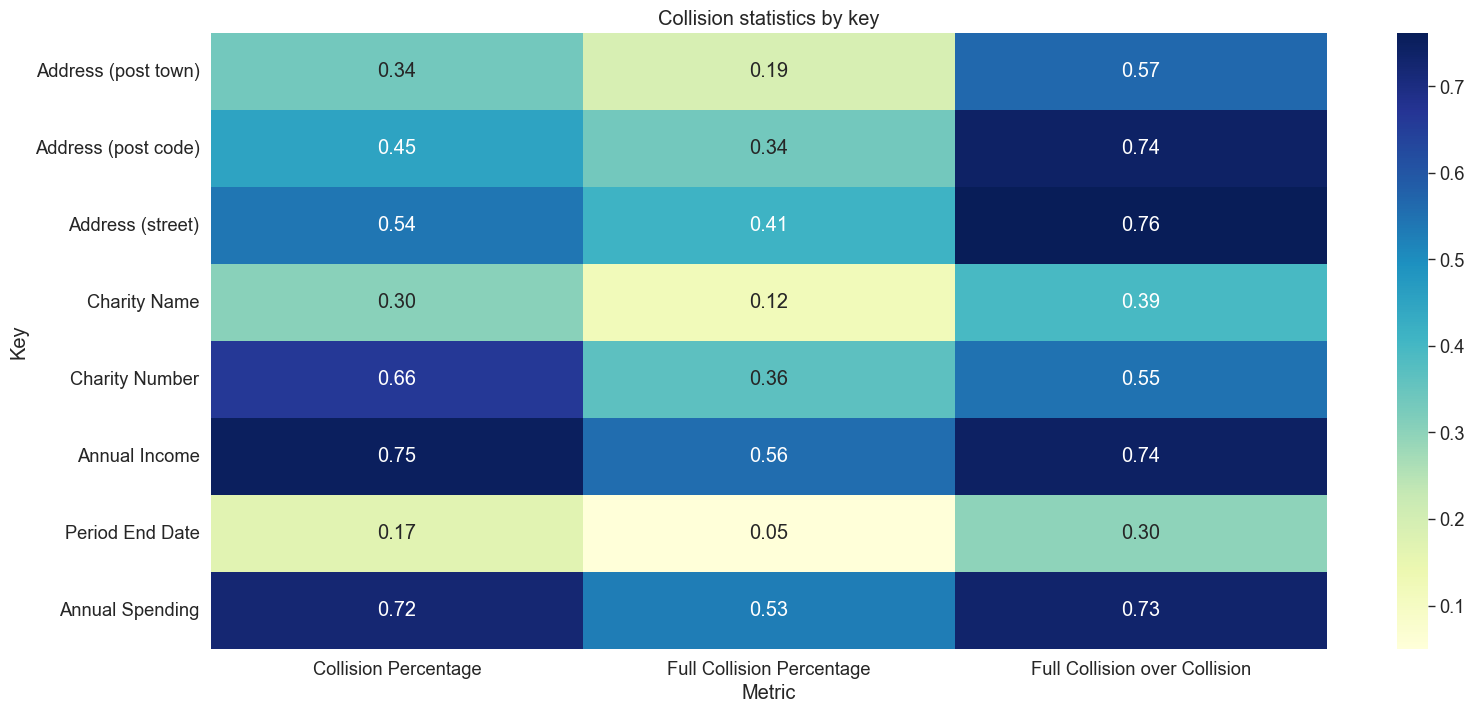

In [50]:
fig, ax = plt.subplots(figsize=(18, 8))

sns.heatmap(combined_runs_key_stats_grouped.iloc[:, 2:], annot=True, fmt=".2f", cmap="YlGnBu", ax=ax)
ax.set(xlabel="Metric", ylabel="Key", title="Collision statistics by key")

ax.set_xticklabels(['Collision Percentage', 'Full Collision Percentage', 'Full Collision over Collision'])

# set the yticks to the key names
ax.set_yticklabels(combined_runs_key_stats_grouped['key'], rotation=0)

plt.show()

fig.savefig(f"plots/{SPLIT}_{MODEL}_{TEMPERATURE}_average_collision_stats_by_key.png", dpi=300)

In [51]:
# attach the own_evaluation.mean(axis=1, skipna=True) to the prediction_stats dataframe
for run_idx, single_run_prediction_stats_df in enumerate(runs_prediction_stats_df):
    single_run_prediction_stats_df['own_evaluation_accuracy'] = own_evaluations[run_idx].mean(axis=1, skipna=True)

runs_prediction_stats_df[0].head()

,num_subdocs,num_unifications,collision_per_key,full_collision_per_key,num_unified_values_per_key,correct_in_any_subdoc_per_key,collision_percentage,full_collision_percentage,correct_in_any_subdoc_percentage,num_non_null_values_per_key,no_collision_percentage,no_collision_percentage_calculated,own_evaluation_accuracy
0,1,0,"{'Address (post town)': None, 'Address (post c...","{'Address (post town)': None, 'Address (post c...","{'Address (post town)': None, 'Address (post c...","{'Address (post town)': False, 'Address (post ...",NaN,NaN,0.750,"{'Address (post town)': 1, 'Address (post code...",NaN,NaN,0.800
1,9,8,"{'Address (post town)': True, 'Address (post c...","{'Address (post town)': True, 'Address (post c...","{'Address (post town)': 2, 'Address (post code...","{'Address (post town)': True, 'Address (post c...",0.750,0.625,0.750,"{'Address (post town)': 2, 'Address (post code...",0.250,0.250,0.375
2,8,8,"{'Address (post town)': True, 'Address (post c...","{'Address (post town)': False, 'Address (post ...","{'Address (post town)': 5, 'Address (post code...","{'Address (post town)': True, 'Address (post c...",0.875,0.125,0.750,"{'Address (post town)': 5, 'Address (post code...",0.125,0.125,0.625
3,2,2,"{'Address (post town)': False, 'Address (post ...","{'Address (post town)': False, 'Address (post ...","{'Address (post town)': 1, 'Address (post code...","{'Address (post town)': True, 'Address (post c...",0.250,0.250,0.750,"{'Address (post town)': 1, 'Address (post code...",0.750,0.750,0.750
4,3,4,"{'Address (post town)': False, 'Address (post ...","{'Address (post town)': False, 'Address (post ...","{'Address (post town)': 1, 'Address (post code...","{'Address (post town)': True, 'Address (post c...",0.250,0.250,0.875,"{'Address (post town)': 1, 'Address (post code...",0.750,0.750,1.000


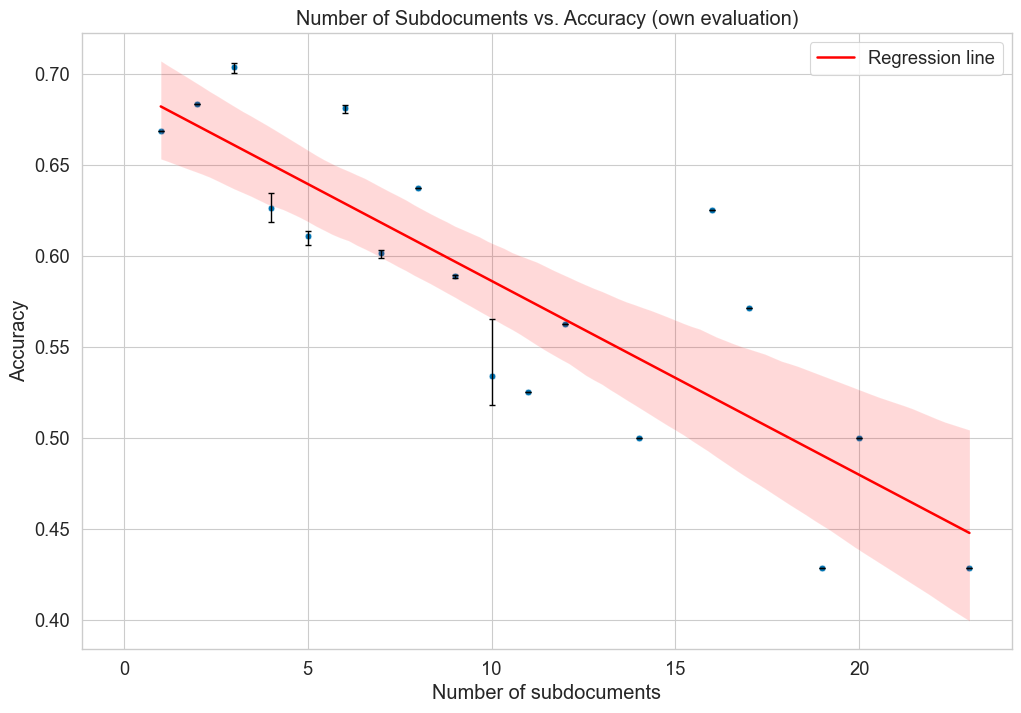

Correlation coefficient: -0.845


In [52]:
fig, ax = plt.subplots(figsize=(12, 8))

max_subdocs = max(runs_prediction_stats_df[0]['num_subdocs'])

x = np.arange(0, max_subdocs+1)
runs_y = []

for run_idx, single_run_prediction_stats_df in enumerate(runs_prediction_stats_df):

    single_run_y = [] # avg. accuracy for each number of subdocs
    # yerr = [] # standard deviation for each number of subdocs

    # scatter plot of the avg. own_evaluation accuracy vs num_subdocs
    for i in range(0, max_subdocs+1):
        single_run_y.append(runs_prediction_stats_df[run_idx][runs_prediction_stats_df[run_idx]['num_subdocs'] == i]['own_evaluation_accuracy'].mean())
        #yerr.append(prediction_stats[prediction_stats['num_subdocs'] == i]['own_evaluation_accuracy'].std())

    runs_y.append(single_run_y)


# combined y is the average of the runs_y
y = np.mean(runs_y, axis=0)

# yerr is the min and max of the runs in runs_y subtracted (for min) and added (for max)
yerr = [[y[i] - min([runs_y[run_idx][i] for run_idx in range(len(runs_y))]) for i in range(len(runs_y[0]))], [max([runs_y[run_idx][i] for run_idx in range(len(runs_y))]) - y[i] for i in range(len(runs_y[0]))]]


ax = sns.scatterplot(x=x, y=y, ax=ax)

# plot the error bars
ax.errorbar(x, y, yerr=yerr, fmt='none', ecolor='black', elinewidth=1, capsize=2)

# regression line
sns.regplot(x=x, y=y, ax=ax, scatter=False, color='red', label='Regression line')

# remove nan values from x and y
x = [x[i] for i in range(len(x)) if not np.isnan(y[i])]
y = [y[i] for i in range(len(y)) if not np.isnan(y[i])]

# set the labels
ax.set(xlabel="Number of subdocuments", ylabel="Accuracy", title="Accuracy by number of subdocuments")
ax.legend(loc='upper right')
ax.set_title("Number of Subdocuments vs. Accuracy (own evaluation)")

plt.show()
fig.savefig(f"plots/{SPLIT}_{MODEL}_{TEMPERATURE}_average_own_eval_accuracy_vs_num_subdocs.png", dpi=300)

print("Correlation coefficient: " + str(round(np.corrcoef(x, y)[0, 1], 3)))